# Draft: Spectral Cube Fitting 

## Imports 

* _time_ for timing 
* _multiprocessing.Pool_ for parallel processing on cube spaxels
* _pickle_ for pickling and unpickling IO to multiprocessing pools
* _numpy_ for array processing and math
* _matplotlib.pyplot_ for plotting images and spectra
* _astropy.io_ for reading and writing FITS cubes and images
* _astropy.visualization_ to construct RGB images
* _lmfit_ Levenberg-Marquart fitting package for model-fitting


In [1]:
import time
import multiprocessing as mp
from multiprocessing import Pool
import pickle

import numpy as np
from numpy import exp, loadtxt, pi, sqrt, arange, interp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.io import fits 
from astropy.visualization import make_lupton_rgb
from astropy import wcs
from astropy.wcs import WCS
import astropy.units as u
from astropy.utils import data
#from spectral_cube import SpectralCube

import lmfit
from lmfit import Model, Minimizer, Parameters
from lmfit.model import save_modelresult


## Introduction
Analysis of JWST spectral cubes requires extracting spatial-spectral features of interest and measuring their
attributes. Here, we demonstrate 1-D spectral modeling applied to an individual spaxel, 900 spaxels in a cube, and spectra summed over spatial regions. Analysis of large JWST spectral data cubes can be computationally expensive, depending on number of spaxels modeled and number of free model parameters. This task can be made manageable by focusing on spatial sub-regions of interest or by minimizing model complexity.  Sub-regions in the cube are selected by location and line ratios. The spaxels in these regions are then summed and modeled with a combination of continuum, emission line, polycyclic aromatic hydrocarbon (PAH), and silicate dust features. Best-fitting model spectra are fit using the lmfit package, utilizing a Levenberg-Marquardt least-squares method. 

## Definitions of functions

### Scrolling
Limit scrolling in cell output.

In [2]:
#%%javascript
#IPython.OutputArea.auto_scroll_threshold=70;
#%matplotlib inline

### Fit and plot single 1D spectrum

In [3]:
def fit_and_plot(spec,specerr,model,generic_pars,silicates=True):
    
    #Fitting
    start_time = time.time()
    result = model.fit(spec, generic_pars, weights=1./specerr, x=x)
    print('Time count')
    print("--- %s seconds ---" % (time.time() - start_time))
    print('Chi square red=',result.redchi)

    #Model Results
    fit_model = result.best_fit 
    fit_residual = spec - fit_model

    #Evaluate model components
    comps = result.eval_components()
    plaw_model=comps['pwl_']
    h2_model=x-x
    h2comp=['h55_','h61_','h69_','h80_','h96_','h122_']
    for comp in h2comp:
        h2_model+=comps[comp]
    ion_model=x-x
    atomiclines=['FeII','ArII','ArIII','SIV','NeII','ClII']
    gaussian_defpar('FeII',0.05, 5.34, 0.053,generic_pars)
    for comp in atomiclines:
        ion_model+=comps[comp+'_']
    pahs_model=fit_model-plaw_model-h2_model-ion_model
    if silicates: 
        sidust_model=comps['sidust1_']
        pahs_model=pahs_model-sidust_model
        
    #Plot results
    fig1=plt.figure(figsize=(15, 6), dpi= 150)
    frame1=fig1.add_axes((.1,.3,.8,.6))
    plt.errorbar(x, spec, yerr=specerr,label='Data', color='k')
    plt.plot(x, fit_model,label='Modelo',c='red')
    if silicates: plt.plot(x,sidust_model,label='Si Dust', c='orange')
    plt.plot(x, pahs_model,label='PAHs',c='magenta')
    plt.plot(x, h2_model,label=r"$H_2$",c='g')
    plt.plot(x, ion_model,label='Iones',c='b')
    plt.ylabel(r"$Flujo\ (Jy)$")
    plt.grid(linestyle=':')
    plt.legend()
    frame1.set_xticklabels([])

    frame2=fig1.add_axes((.1,.1,.8,.2))
    plt.errorbar(x,fit_residual,yerr=specerr)
    plt.plot(x, 0.*x, '-')
    plt.xlabel(r"$Longitud\ de\ Onda\ (\mu m)$")
    plt.grid(linestyle=':')
    plt.show()     
    return result


### Save emission map to fits

In [4]:
def map2file(cube,map_array,filename):
    """Save a map array to FITS"""
    aux=cube
    aux[0].data = map_array
    name=str(name)
    aux.writeto(name)

### Model Functions
A variety of emission line, continuum and extinction models for spectral fitting.

In [5]:
def gaussian(x, amplitude, xcen, std):
    """1-d gaussian"""
    return amplitude * exp(-(x-xcen)**2 / (2*std**2))                           #Amplitude unit

def linear(x, slope, intercept):
    """a linear function"""
    return slope*x + intercept

def powerlaw(x, c1, c2):
    """power law function"""
    return c1*(x**c2)

def drude(x, peakx, frac_FWHM, amplitude):
    """dust emission"""
    return ((amplitude*(frac_FWHM**2))/((x/peakx-peakx/x)**2+frac_FWHM**2))    #Amplitude unit

def pahdust(x, Oneplusz, amplitude_76, amplitude_113):
    """PAH dust emission"""
    
    #Ionized PAH features
    ionPAH_peakx=     [ 5.27, 5.70, 6.22, 6.69, 7.42, 7.60, 7.85, 8.33, 8.61]
    ionPAH_frac_FWHM= [0.034,0.035, 0.030,0.07, 0.126,0.044,0.053,0.050, 0.039]
    ionPAH_amplitude= [0.0,  0.0,   0.8,  0.0,  0.0,  1.0,  0.6,  0.0,   0.5]
    
    pahflux=x-x
    for peakx, frac_FWHM, ampl in zip(ionPAH_peakx,ionPAH_frac_FWHM,ionPAH_amplitude):
        peakx=peakx*Oneplusz
        ampl=amplitude_76*(ampl/ionPAH_amplitude[5])
        pahflux=pahflux+((ampl*(frac_FWHM**2))/((x/peakx-peakx/x)**2+frac_FWHM**2))

    #Neutral PAH features
    neutralPAH_peakx=     [10.68, 11.23,11.33]
    neutralPAH_peakx+=    [11.99,12.62,12.69,13.48,14.04,14.19,15.90, 16.45,17.04,17.375,17.87,18.92]
    neutralPAH_frac_FWHM= [0.020, 0.012,0.022]
    neutralPAH_frac_FWHM+=[0.045,0.042, 0.013,0.040,0.016,0.025,0.020,0.014,0.065, 0.012, 0.016,0.019]   
    neutralPAH_amplitude= [0.0,  0.6, 1.0]
    neutralPAH_amplitude+=[0.2,  0.3,   0.1,  0.0,  0.1,  0.1,  0.0,   0.0,  0.0,  0.0,   0.0,  0.0]
    
    for peakx, frac_FWHM, ampl in zip(neutralPAH_peakx,neutralPAH_frac_FWHM,neutralPAH_amplitude):
        peakx=peakx*Oneplusz
        ampl=amplitude_113*(ampl/neutralPAH_amplitude[2])
        pahflux=pahflux+((ampl*(frac_FWHM**2))/((x/peakx-peakx/x)**2+frac_FWHM**2))

    return pahflux    #Amplitude unit

def sidust(x, T, amplitude):
    """Silicate dust emission"""
    
    #pahfit_tau_agn -- Custom extinction curve built from weighted sum of two components: 
    #                  silicate profile (Drude functions), and an exponent 1.7 power-law.

    d1=drude(x,10.0,0.25,0.80)
    d2=drude(x,11.1,0.25,0.25)
    #d3=drude(x,17.0,0.40,0.40)
    ext=d1+d2  #+d3

    # Form linear combination of modified silicate and powerlaw.
    beta=0.1
    ext=(1. - beta)*ext + beta*(9.7/x)**1.7
    scale=1.0E-6
    si_em=amplitude*1.0E-6*3.97289E13/x**3/(exp(1.4387752E4/x/T)-1.)*ext
    
    return si_em

def blackbody(x, OnePlusZ, T, K):
    """black body function"""
    h=6.626196*10**(-27) #erg*s
    c=2.997924562*10**(10) #cm/s
    k=1.38*10**(-16) #erg/K
    Constant = 1.71828182846 / OnePlusZ
    EnergyRatio = ((1./(k*T))*OnePlusZ*h*c*10000)/x
    return Constant*K*(EnergyRatio**4)/(exp(EnergyRatio)-1.)                   #Jansky unit

def extinctiongal(x, tau):
    """Galactic center extinction"""
    return exp(-tau*agal)

def extinctionloc(x, tau):
    """Local ISM extinction"""
    return exp(-tau*alocal_int)

#Read extinction data from Chiar & Tielens (2005)
wave, agal, alocal = np.loadtxt('chiar+tielens_2005.dat', skiprows=14, usecols=(0, 1, 2), unpack=True)

def gaussian_flux(x, ratio, xcen, std):
    """Same model of gaussian but with ratio"""
    amp=gauss_flux2amp(ratio,std,xcen)
    return gaussian(x, amp, xcen, std)

def drude_flux(x, peakx, frac_FWHM, ratio):
    """Same model of drude but with ratio"""
    amp=drude_flux2amp(ratio,frac_FWHM,peakx)
    return drude(x, peakx, frac_FWHM, amp)

def Modelcero(x):
    """Simple model of 0 to initialize some models"""
    return 0*x

def Modelconst(x,A):
    """Simple model of a constant"""
    return (0*x)+A

### Calculate Line Flux and Line Width
Helper functions to calculate the fluxes and widths of emission features from model parameters.

In [6]:
def fwhm2std(fwhm):
    """from fwhm to standard deviation of a gaussian"""
    return fwhm/2.355

def gaussianline_flux(amp,std,cen):
    """calculate the integrate flux for a gaussian line"""
    #Units= amp:Jy cen:microns
    c= 29979.2458*10**10 #c in microns/s
    gaussianfactor=sqrt(2*pi)
    return amp*gaussianfactor*c*std/(cen**2)*10**(-23)      #erg s^{-1} cm^{-2}

def drudeline_flux(amp,frac,peak):
    """calculate the integrate flux for a drude line"""
    #Units= amp:Jy peak:microns
    c= 29979.2458*10**10 #c in microns/s
    drudefactor=pi
    return (amp*frac*drudefactor*c/((2*peak)))*10**(-23)   #erg s^{-1} cm^{-2}

def drude_flux2amp(flux,frac,peak):
    """calculate the amplitude from a flux for a drude line"""
    c= 29979.2458*10**10 #c in microns/s
    drudefactor=pi
    amp=(flux*2*peak)/(frac*drudefactor*c*10**(-23))
    return amp

def gauss_flux2amp(flux,std,peak):
    """calculate the amplitude from a flux for a gauss line"""
    c= 29979.2458*10**10 #c in microns/s
    gaussianfactor=sqrt(2*pi)
    amp=(flux*peak**2)/(gaussianfactor*c*std*10**(-23))
    return amp

## Model Parameters 
Declare the parameters of model functions. Parameters are frozen by setting vary='False'
in the lmfit setpar command.  For now we are just fitting amplitudes of emission features.
Fits with more variable parameters take longer.

In [7]:
def setpar(pars,name,value,vary,minus):
    """Set any parameter"""
    pars[name].set(value,vary=vary,min=minus)
    
def extracpar(result,name):
    value=result.params[name].value
    return value

def gaussian_defpar(name,amplitude,xcen,fwhm,pars):
    """set the parameters for a gaussian"""
    std=fwhm2std(fwhm)
    name=str(name)
    xcen=xcen*OneZ
    setpar(pars,name+'_std',std,False,None)
    #setpar(pars,name+'_std',std,True,0)
    setpar(pars,name+'_xcen',xcen,False,None)
    setpar(pars,name+'_amplitude',amplitude,True,0)
    return #pars[name+'_std'].set(std,vary=False),pars[name+'_xcen'].set(xcen,vary=False),pars[name+'_amplitude'].set(amplitude)

def drude_defpar(name, peakx, frac_FWHM, amplitude, pars):
    """set the parameters for a drude"""
    peakx=peakx*OneZ
    setpar(pars,name+'_frac_FWHM',frac_FWHM,False,None)
    #setpar(pars,name+'_frac_FWHM',frac_FWHM,True,0)
    setpar(pars,name+'_peakx',peakx,False,None)
    setpar(pars,name+'_amplitude',amplitude,True,0)    
    return #pars[name+'_frac_FWHM'].set(frac_FWHM,vary=False),pars[name+'_peakx'].set(peakx,vary=False),pars[name+'_amplitude'].set(amplitude)

def pahdust_defpar(name, Oneplusz, amplitude_76, amplitude_113, pars):
    """set the parameters for pdr dust"""
    setpar(pars,name+'_amplitude_76',amplitude_76,True,0) 
    setpar(pars,name+'_amplitude_113',amplitude_113,True,0) 
    setpar(pars,name+'_Oneplusz',Oneplusz,False,None)
    return #pars[name+'_frac_FWHM'].set(frac_FWHM,vary=False),pars[name+'_peakx'].set(peakx,vary=False),pars[name+'_amplitude'].set(amplitude)

def sidust_defpar(name,T,amplitude,pars):
    setpar(pars,name+'_amplitude',amplitude,True,0)
    setpar(pars,name+'_T',T,False,0)
    return

def gaussian_extractpars(prefix,result):
    """extract the parameters for a gaussian"""
    amp = result.params[prefix+'amplitude'].value
    cen = result.params[prefix+'xcen'].value
    std = result.params[prefix+'std'].value
    return amp, cen, std

def drude_extractpars(prefix,result):
    """extract the parameters for a drude"""
    ampl = result.params[prefix+'amplitude'].value
    peak = result.params[prefix+'peakx'].value         
    frac = result.params[prefix+'frac_FWHM'].value
    return ampl, peak, frac

def pahdust_extractpars(prefix,result):
    """extract the parameters for pahdust model"""
    ampl_76 = result.params[prefix+'amplitude_76'].value
    ampl_113 = result.params[prefix+'amplitude_113'].value
    return ampl_76, ampl_113  

def sidust_extractpars(prefix,result):
    """extract the parameters for pahdust model"""
    T = result.params[prefix+'T'].value
    ampl = result.params[prefix+'amplitude'].value
    
    return T,ampl 

def wave2cubecoor(wave,xwanted):
    """from wavelenght to coordinate in the cube"""
    count=0
    for line in wave:
        line=float(line)
        if abs(line-xwanted)<=0.001:
            coowanted=count
        else:
            count=count+1
    return coowanted

def map2file(cube,map_array,filename):
    """Save a map array to FITS"""
    aux=cube
    aux[0].data = map_array
    name=str(filename)
    aux.writeto(name)

In [8]:
def extract_spec(a, b):
    """extract spec and errors from a,b coordinates"""
    spec_pix=data_cube[:,a,b]
    err_pix=error_cube[:,a,b]
    return spec_pix, err_pix

def model_comps(model_result):
    """Evaluate model components"""
    comps = model_result.eval_components()
    plcomp=[]
    h2comp=[]
    pahcomp=[]
    sidustcomp=[]
    #print(comps.keys())
    for key in comps.keys(): 
        keyl=key.lower()
        if keyl[0:3]=='pwl': plcomp.append(key)
        if keyl[0]=='h': h2comp.append(key)
        if keyl[0:3]=='pah': pahcomp.append(key)
        if keyl[0:3]=='sid': sidustcomp.append(key)
       
    plaw_model=x-x
    h2_model=x-x
    ion_model=x-x
    pah_model=x-x
    sidust_model=x-x
    for comp in plcomp: plaw_model+=comps[comp]
    for comp in h2comp: h2_model+=comps[comp]
    for comp in pahcomp: pah_model+=comps[comp]
    for comp in sidustcomp: sidust_model+=comps[comp]
    atomiclines=['ArII','SIV','NeII']
    for comp in atomiclines:
        ion_model+=comps[comp+'_']
        
    return([plaw_model,h2_model,ion_model,pah_model,sidust_model],['PL','H2','Ions','PAHs','Si Dust'])

def plot_fit(x, spec, specerr, model_result):
    """plot spectrum, model components, and residual"""

    #Model Results
    fit_model = model_result.best_fit 
    fit_residual = spec - fit_model

    #Evaluate model components
    mod_comps,mod_labels=model_comps(model_result)
        
    #Spec-1D object
    spec1 = Spectrum1D(spectral_axis=x* u.um, flux=spec*u.Jy, uncertainty=StdDevUncertainty(specerr))
    with quantity_support():    
        f, ax = plt.subplots()  
        #ax.step, ax.plot, ax.scatter all work, but ax.scatter doesn't autscale correctly
        ax.plot(spec1.spectral_axis, spec1.flux,label='Data', color='k')
        #ax.set_xlabel(r"$Wavelength\ (\mu m)$")
        ax.grid(linestyle=':')
        #plt.errorbar only works on unitless data
        #ax.errorbar(spec1.spectral_axis, spec1.flux, yerr=specerr,label='Data', color='k')
        #ax.plot(spec1.spectral_axis, spec1.flux, yerr=specerr,label='Data', color='k')
        
        plt.show()   

    #Plot results
    fig1=plt.figure(figsize=(15, 6), dpi= 150)
    
    frame1=fig1.add_axes((.1,.3,.8,.6))
    frame1.set_xticklabels([])
    plt.ylabel(r"$Flux\ (Jy)$")
    plt.grid(linestyle=':')
    plt.errorbar(x, spec, yerr=specerr,label='Data', color='k')
    plt.plot(x, fit_model,label='Model',c='red')
    mod_colors=['brown','g','b','magenta','orange']
    for mcomp, mlabel, mcolr in zip(mod_comps,mod_labels,mod_colors):
        plt.plot(x, mcomp, label=mlabel, c=mcolr)        
    plt.legend()

    frame2=fig1.add_axes((.1,.1,.8,.2))
    plt.plot(x, 0.*x, '-',c='r')
    plt.xlabel(r"$Wavelength\ (\mu m)$")
    plt.grid(linestyle=':')
    plt.errorbar(x,fit_residual,yerr=specerr,c='k')

    plt.show()     
    return 

## Input data
With the present lack of JWST flight data, we utilize the SL1 and SL2 spectral cubes generated
using CUBISM, from Spitzer IRS spectral mapping observations of the center of nearby
galaxy Messier 58. This galaxy has a radio-loud Seyfert nucleus that is exciting strong
H2 emission via shocks.  There is also significant star-formation, revealed by PAH emission
features.

Trimmed cube dimensions: 194 30 32


/home/ivan/soft/miniconda3/envs/astropy/lib/python3.5/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


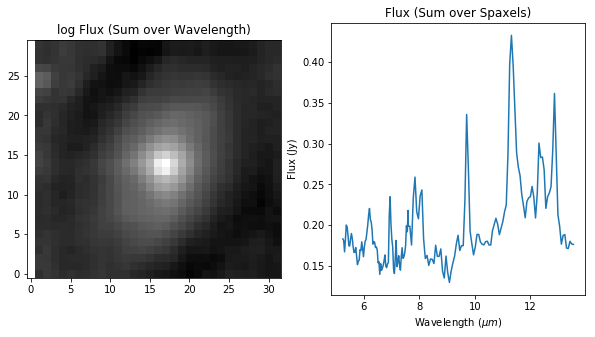

In [9]:
#Target 
targname='M58'

#Redshift
z=0.005060
OneZ=1.+z

#Open the data and errors
cubeSL1 = fits.open(targname+'_SL1_cube.fits') 
errorsSL1 = fits.open(targname+'_SL1_cube_unc.fits')
cubeSL2 = fits.open(targname+'_SL2_cube.fits') 
errorsSL2 = fits.open(targname+'_SL2_cube_unc.fits')

#Cube Info
#cubeSL1.info()
#cubeSL2.info()

#Headers
hdr1 = cubeSL1[0].header                        
er_hdr1=errorsSL1[0].header
hdr2 = cubeSL2[0].header                               
er_hdr2=errorsSL2[0].header
#print(repr(hdr1))

#Data
data_cube1=[]
error_cube1=[]
wave1=[]
data_cube2=[]
error_cube2=[]
wave2=[]
data_cube1 = cubeSL1[0].data
error_cube1 = errorsSL1[0].data
data_cube2 = cubeSL2[0].data
error_cube2 = errorsSL2[0].data

#Wavelength
xwave1 = cubeSL1[1].data
xwave1 = xwave1.field(0)[0]
xwave2 = cubeSL2[1].data
xwave2 = xwave2.field(0)[0]
x=[]
for line in xwave2:
    x.append(float(line))
for line in xwave1:
    x.append(float(line))
x=np.array(x)

#Change the units from MJy/sr to Jy/pix
correct_unit1=abs(hdr1['CDELT1'])*abs(hdr1['CDELT2'])*0.0003046118*(10**6)    
data_cube1=data_cube1*correct_unit1
error_cube1=error_cube1*correct_unit1
correct_unit2=abs(hdr2['CDELT1'])*abs(hdr2['CDELT2'])*0.0003046118*(10**6)    
data_cube2=data_cube2*correct_unit2
error_cube2=error_cube2*correct_unit2

#Concatenate SL1 and SL2
data_cube=np.concatenate((data_cube2,data_cube1),axis=0)
error_cube=np.concatenate((error_cube2,error_cube1),axis=0)

#Reorder x and data_cube
xcor = x.argsort()
data_cube = data_cube[xcor]
error_cube = error_cube[xcor]
x=np.sort(x)

#Cube dimensions and trimming 
xsize, ysize, zsize = data_cube.shape
ytrim=0; ysize=ysize-ytrim
ztrim=3; zsize=zsize-ztrim

print('Trimmed cube dimensions:', xsize, ysize, zsize)

#Test output
#map2file(cubeSL2,data_cube,'test2.fits')
#Interpolate the extintion data in the x vector
ext=np.interp(x, wave, alocal)

#Collapsed 2D image
cube_2dflux=np.sum(data_cube,axis=0)[0:ysize,0:zsize]

#Collapsed 1D spectrum
cube_1dflux=np.zeros(xsize,)
for a in arange(0,ysize):
    for b in arange(0,zsize):
        spec_pix,err_pix=extract_spec(a,b)
        cube_1dflux=cube_1dflux+spec_pix

f,(ax1,ax2)=plt.subplots(1,2, figsize=(10,5))
ax1.set_title('log Flux (Sum over Wavelength)')
ax1.imshow(cube_2dflux, origin='lower', cmap='gray', norm=LogNorm())
ax2.set_title('Flux (Sum over Spaxels)')
ax2.plot(x,cube_1dflux)
ax2.set_xlabel(r"Wavelength $(\mu m)$")
ax2.set_ylabel('Flux (Jy)')
plt.show()

## Extract WCS

#### We extract the WCS from the cube, and eliminate the spectral information to obtain a WCS for the maps

In [10]:
#cubeSL1.info()
#Fake WCS for the outputs
cubeSL1 = fits.open(targname+'_SL1_cube.fits') 
fake_wcs = cubeSL1[0].header
fake_wcs['NAXIS']=2
fake_wcs['NAXIS1']=32
del fake_wcs[5]
del fake_wcs[27:35]

wcs_cube = WCS(fake_wcs)
wcs_cube

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 189.431036872  11.8180033864  
CRPIX : 18.0  15.5  
PC1_1 PC1_2  : 0.233824511547  0.972278816904  
PC2_1 PC2_2  : -0.972278816904  0.233824511547  
CDELT : -0.000513888895512  0.000513888895512  
NAXIS : 32  30

#### To obtain the RA values in the most spreaded axis, we rotated the figures

/home/ivan/soft/miniconda3/envs/astropy/lib/python3.5/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/ivan/soft/miniconda3/envs/astropy/lib/python3.5/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/ivan/soft/miniconda3/envs/astropy/lib/python3.5/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


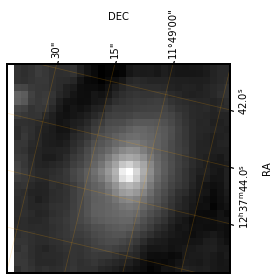

In [11]:
cube_2dflux=np.sum(data_cube,axis=0)[0:ysize,0:zsize]

fig = plt.subplots(figsize=(4,4),)
ax = plt.subplot(111, projection=wcs_cube)
ax.imshow(cube_2dflux,origin='lower',cmap='gray', norm=LogNorm())
ax.grid(color='orange', alpha=0.2, ls='solid')
ra = ax.coords['ra']
dec = ax.coords['dec']
#ra.set_ticks(number=10, exclude_overlapping=True)
#dec.set_ticks(number=8, exclude_overlapping=True)


dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)


ra.set_axislabel('RA', minpad=-26)
dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
#ra.display_minor_ticks(True)
#dec.display_minor_ticks(True)
#dec.set_minor_frequency(2)
#ra.set_minor_frequency(2)

ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
#ra.set_

ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax.coords.frame.set_linewidth(2)

### Check conditions

#### If there are spaxels with a few Nan values (less than 10%), we interpolate the missing values.

In [12]:
## Nan Policy - Interpolate values if the nan values are less than 10% of the data
astart=0; aend=ysize
bstart=0; bend=zsize
nan_cube=np.zeros((ysize, zsize))

for a in np.arange(astart,aend):
    for b in np.arange(bstart,bend):        
        nancheck = False
        count=0
        for point in data_cube[:,a,b]:
            if np.isnan(point)==True:
                count+=1
        if count>0 and count<=0.1*xsize:
            A = data_cube[:,a,b]
            ok = ~np.isnan(A)
            xp = ok.ravel().nonzero()[0]
            fp = A[~np.isnan(A)]
            xn  = np.isnan(A).ravel().nonzero()[0]
            A[np.isnan(A)] = np.interp(xn, xp, fp)
            data_cube[:,a,b]=A
        count=0
        for point in error_cube[:,a,b]:
            if np.isnan(point)==True:
                count+=1
        if count>0 and count<=0.1*xsize:
            A = error_cube[:,a,b]
            ok = ~np.isnan(A)
            xp = ok.ravel().nonzero()[0]
            fp = A[~np.isnan(A)]
            xn  = np.isnan(A).ravel().nonzero()[0]
            A[np.isnan(A)] = np.interp(xn, xp, fp)
            error_cube[:,a,b]=A
            
#Check zeros in the array and replace with a small number to better condition number of the matrix

for a in np.arange(astart,aend):
    for b in np.arange(bstart,bend):        
        nancheck = False
        count=0
        for point in data_cube[:,a,b]:
            if point==0:
                data_cube[count,a,b]=1e-10
            count+=1

## Model Parameter Starting Values
Set starting parameters for spectral model components. Use a PAH dust model with only two free parameters (7.6 and 11.3 micron PAH flux).  The rest of the PAH ratios are fixed by this 'pahdust' model, so that fitting the whole cube does not take so long.   Later, we will fit summed region spectra with all PAH amplitudes free.

In [13]:
#Power Law
p_law = Model(powerlaw,prefix='pwl_')
generic_pars = p_law.make_params()      
setpar(generic_pars,'pwl_c1',0.000002,True,None)
setpar(generic_pars,'pwl_c2',0.000015,True,None)

#PAH dust model with fixed PAH feature ratios
prefix='pahdust1_'
pahs = Model(pahdust,prefix=prefix)
generic_pars.update(pahs.make_params())
#print(generic_pars)
pahdust_defpar('pahdust1',1.00506,0.00003,0.005,generic_pars)

#Silicate dust emission
prefix='sidust1_'
silicate= Model(sidust,prefix=prefix)
generic_pars.update(silicate.make_params())
sidust_defpar('sidust1', 190.,1.E-4,generic_pars)

#Gaussians with FWHM and X central from Smith et al 2007
#H2 molecular
h2lines=['55','61','69','80','96','122']
gaussH2=Model(Modelcero)
for line in h2lines:
    prefix='h'+line+'_'
    gaussH2+=Model(gaussian,prefix=prefix)
generic_pars.update(gaussH2.make_params())
gaussian_defpar('h55',0.0005, 5.511, 0.053,generic_pars)
gaussian_defpar('h61',0.0005, 6.109, 0.053,generic_pars)
gaussian_defpar('h69',0.005, 6.909, 0.053,generic_pars)
gaussian_defpar('h80',0.005, 8.026, 0.100,generic_pars)
gaussian_defpar('h96',0.005, 9.665, 0.100,generic_pars)
gaussian_defpar('h122',0.0005, 12.278, 0.100,generic_pars)

#Atomic lines
atomiclines=['FeII','ArII','ArIII','SIV','NeII','ClII']
gaussAt=Model(Modelcero)
for line in atomiclines:
    prefix = line+'_'
    gaussAt+=Model(gaussian,prefix=prefix)
generic_pars.update(gaussAt.make_params())
gaussian_defpar('FeII',0.0005, 5.34, 0.053,generic_pars)
gaussian_defpar('ArII',0.005, 6.985, 0.053,generic_pars)
gaussian_defpar('ArIII',0.0005, 8.991, 0.100,generic_pars)
gaussian_defpar('SIV',0.0005, 10.511, 0.100,generic_pars)
gaussian_defpar('NeII',0.05, 12.813, 0.100,generic_pars)
gaussian_defpar('ClII',0.005, 14.37, 0.100,generic_pars) #This line can be also NeV (14.3 microns)

In [14]:
#Ext
extin=Model(extinctionloc,prefix='ext_')
generic_pars.update(extin.make_params())
setpar(generic_pars,'ext_tau',0.000000002,True,None)
alocal_int=ext

## Fit a Representative Spaxel
Fit a collapsed spectrum (5:25,5:25) and use the fit parameters to adjust the generic model starting parameters.

Time count
--- 80.72758889198303 seconds ---
Chi square red= 67.33731903665553


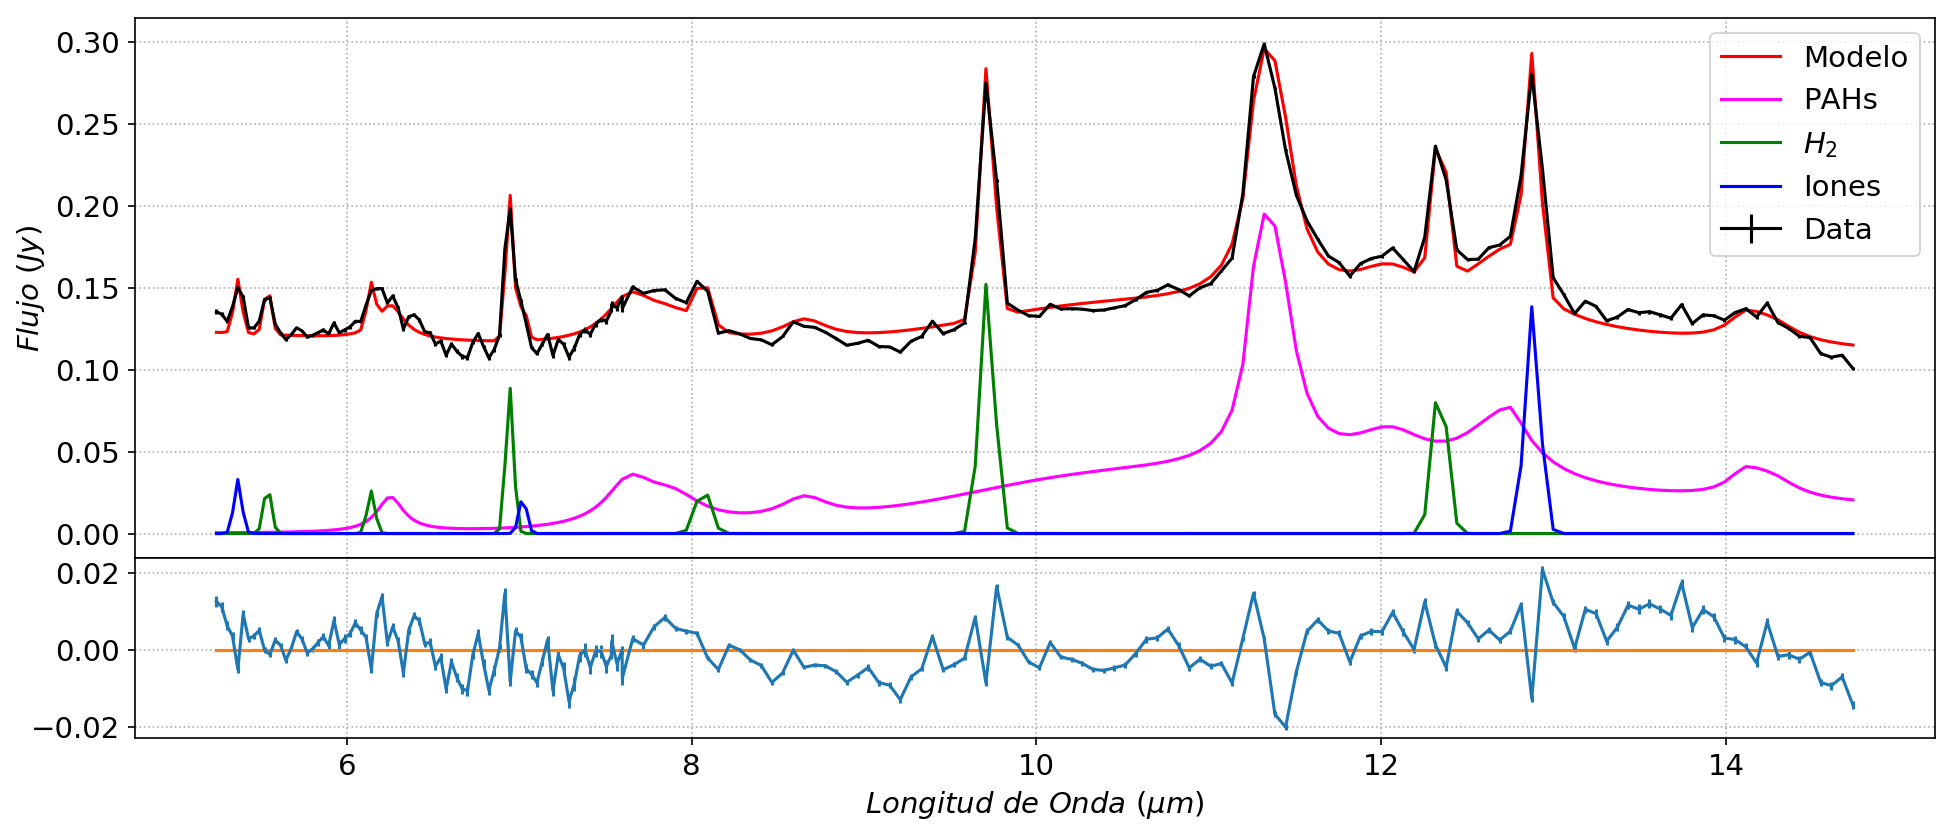

[[Model]]
    ((((Model(powerlaw, prefix='pwl_') + Model(pahdust, prefix='pahdust1_')) + ((((((Model(Modelcero) + Model(gaussian, prefix='h55_')) + Model(gaussian, prefix='h61_')) + Model(gaussian, prefix='h69_')) + Model(gaussian, prefix='h80_')) + Model(gaussian, prefix='h96_')) + Model(gaussian, prefix='h122_'))) + ((((((Model(Modelcero) + Model(gaussian, prefix='FeII_')) + Model(gaussian, prefix='ArII_')) + Model(gaussian, prefix='ArIII_')) + Model(gaussian, prefix='SIV_')) + Model(gaussian, prefix='NeII_')) + Model(gaussian, prefix='ClII_'))) + Model(sidust, prefix='sidust1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37941
    # data points      = 194
    # variables        = 18
    chi-square         = 11851.3682
    reduced chi-square = 67.3373190
    Akaike info crit   = 833.794045
    Bayesian info crit = 892.615492
##  Warning: uncertainties could not be estimated:
    pahdust1_Oneplusz:       at initial value
    sidust1_T:               

In [15]:
#Collapsed 1D spectrum
cube_1dflux=np.zeros(xsize,)
cube_1derr=np.zeros(xsize,)
for a in arange(5,25):
    for b in arange(5,25):
        spec_pix,err_pix=extract_spec(a,b)
        cube_1dflux=cube_1dflux+spec_pix
        cube_1derr=cube_1derr+err_pix**2

spec=cube_1dflux
specerr=sqrt(cube_1derr)


#Composite model (powerlaw + PAHs + H2 + Atomic lines, no extinction)
generic_mod = (p_law  + pahs + gaussH2 + gaussAt + silicate)

#Fit and plot
plt.rcParams.update({'font.size': 14})

spax_result=fit_and_plot(spec,specerr,generic_mod,generic_pars,False)

#Save results
save_modelresult(spax_result, 'OnePointResult.sav')


print(spax_result.fit_report(show_correl=True))


#Update generic model starting parameters
for par in spax_result.params:
    value=spax_result.params[par].value
    vary=spax_result.params[par].vary
    minus=spax_result.params[par].min
    if minus==float("-inf"):
        minus=None
    generic_pars[par].set(value,vary=vary,min=minus)
    

Plot of observed flux density (black), model fit (red), and residuals (bottom panel).  This spectra has strong H2 emission at 9.6 microns and 8 micron PAH and [Ne II] 12.8 micron emission from star-forming regions.

--To obtain errors, we need to fix values near zero, and re-run the previous cell--


#### However, we don't want fix values before the fitting of the whole cube. 

## Fit the Entire Cube
Identify NaNs, then create list of models (based on generic model), one entry per NaN-free spaxel. Next launch the multiprocessing Pool, limited to number of available cores minus one. Fitting the entire cube (900 spaxels) takes about 2 minutes to fit with 7 processes running in parallel.

### To fit the cube, change the next cell to "code" and run it

cube_res = mp.Manager().dict()

#The fit method is redefined as a top-level function to make it pickle-able for multiprocessing.Pool
def modfit(spaxel, generic_pars, weights, x):
        modf=generic_mod.fit(spaxel, generic_pars, weights=1./spaxerr, x=x)
        return modf.dumps()

#Helper to either assign a NaN result or fit a single non-NaN spaxel
def fit_point(args):
        a,b,spaxel,spaxerr,x,generic_pars,nancheck = args
        print(a, b, len(spaxel), mp.current_process().name)
        if nancheck == False:
            cube_res[(a,b)] = modfit(spaxel, generic_pars, weights=1./spaxerr, x=x)
        elif nancheck == True:
            cube_res[(a,b)] = float('nan')
        return 

#Extraction region dimensions (trimmed cube)
astart=0; aend=ysize
bstart=0; bend=zsize

#Check for NaNs, select data, and set model start parameters for each spaxel
pooldata=[]
for a in np.arange(astart,aend):
    for b in np.arange(bstart,bend):        
        nancheck = False
        for point in data_cube[:,a,b]:
            if np.isnan(point) == True or point == 0:
                nancheck = True
        
        #Copy spaxel data vectors
        spaxel = 1.0*np.array(data_cube[:,a,b])
        spaxerr= 1.0*np.array(error_cube[:,a,b])
        wavelen= 1.0*np.array(x)
        
        pooldata.append([a,b,spaxel,spaxerr,wavelen,generic_pars,nancheck])


#Launch Multiprocessing Pool
start_time = time.time()
if __name__ == '__main__':
    with Pool(mp.cpu_count() - 1) as pool:
        pool.map(fit_point,pooldata)    

print('Time count')
print("--- %s seconds ---" % (time.time() - start_time))

#Save model fit
with open('MPF_cube_result_model_27Jun.sav', 'wb') as fp:
    pickle.dump(cube_res.items(), fp)

In [16]:
#Load model fit to full cube
cube_res = mp.Manager().dict()
with open ('MPF_cube_result_model_27Jun.sav', 'rb') as fp:
        restore_cube = pickle.load(fp)
for line in restore_cube:
    pos=line[0]
    cube_res[pos] = line[1]

### Total flux and Reduced Chi^2 Maps
Display total flux image (observed flux cube collapsed along wavelength direction), residuals and reduced Chi^2 image for model fit in square sub-region.

In [17]:
#Sum observed flux in each spaxel
cube_tflux=np.sum(data_cube,axis=0)[0:ysize,0:zsize]

#Sum model flux in each spaxel
tcube_chi=np.zeros((ysize, zsize))
tcube_modflux=np.zeros((ysize, zsize))
funcdefs = {'powerlaw': powerlaw, 'Modelcero':Modelcero, 'pahdust':pahdust, 'sidust':sidust, 'gaussian':gaussian}
modres = lmfit.model.ModelResult(lmfit.Model(gaussian), lmfit.Parameters())
for pos, dumpval in cube_res.items():
    #for pos, dumpval in cube_res:
    if str(cube_res[pos])=='nan':
        tcube_modflux[pos]=float('nan')
        tcube_chi[pos]=float('nan')
    else:
        result = spax_result.loads(dumpval, funcdefs=funcdefs)
        tcube_modflux[pos]=np.sum(result.best_fit)
        tcube_chi[pos]=result.redchi

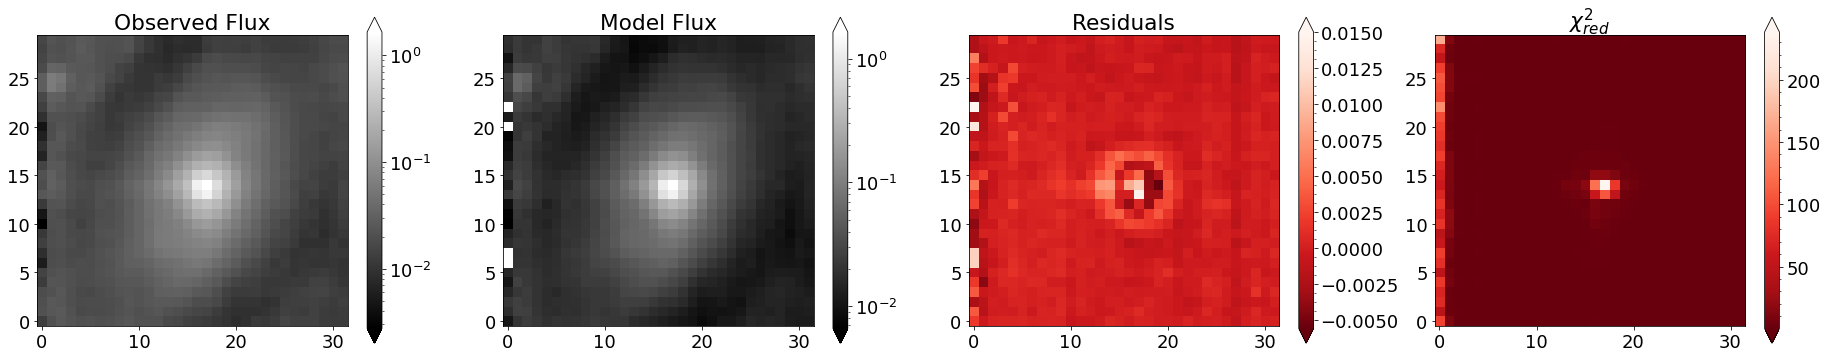

In [18]:
plt.rcParams.update({'font.size': 18})

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(32, 6), ncols=4)
pos1 = ax1.imshow(cube_tflux, origin='lower', cmap='gray', norm=LogNorm(), interpolation='none')
ax1.set_title('Observed Flux')
cbar = fig.colorbar(pos1, ax=ax1, extend='both')

pos2 = ax2.imshow(tcube_modflux, origin='lower', cmap='gray', norm=LogNorm(), interpolation='none')
ax2.set_title('Model Flux')
cbar = fig.colorbar(pos2, ax=ax2, extend='both')


pos3 = ax3.imshow(cube_tflux-tcube_modflux, origin='lower', cmap='Reds_r',interpolation='none')

ax3.set_title('Residuals')
cbar = fig.colorbar(pos3, ax=ax3, extend='both')
cbar.minorticks_on()

pos4 = ax4.imshow(tcube_chi, origin='lower', cmap='Reds_r',interpolation='none')
ax4.set_title(r"$\chi^2_{red}$")
cbar = fig.colorbar(pos4, ax=ax4, extend='both')
cbar.minorticks_on()
plt.show()


Collapsed cube maps, showing observed flux, model flux, and Chi^2/DF.  White regions with NaNs in the input data cube also have NaNs in the output model cube along the left and top edges and in column 26.  Residuals in the nucleus may either be the result of inadequate PSF sampling or mis-fit AGN model.

### Line maps
Create H2 9.6 micron, [Ne II] 12.8 micron, PAH 7.6, and PAH 11.3 micron line maps for 3-color image.

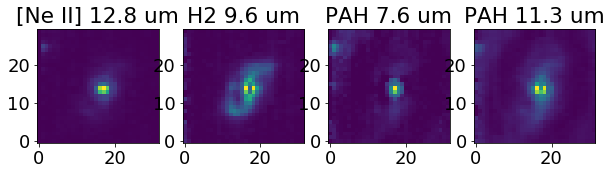

In [19]:
h2cube_flux=np.zeros((ysize, zsize))
necube_flux=np.zeros((ysize, zsize))
pahcube_ion_flux=np.zeros((ysize, zsize))
pahcube_neutral_flux=np.zeros((ysize, zsize))

line='96'
i=0
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        h2cube_flux[pos]=float('nan')
    else:
        lflux=0.
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = 'h'+line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        h2cube_flux[pos]=lflux

line='NeII'
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        necube_flux[pos]=0.0
    else:
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        necube_flux[pos]=lflux

line='pahdust1'
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        pahcube_ion_flux[pos]=float('nan')
        pahcube_neutral_flux[pos]=float('nan')
    else:
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = line+'_'
        ampl_76, ampl_113 = pahdust_extractpars(prefix,result)  
        pah_76_flux = drudeline_flux(ampl_76,0.044,7.60)
        pah_113_flux = drudeline_flux(ampl_113,0.032,11.33)                      
        pahcube_ion_flux[pos]=pah_76_flux
        pahcube_neutral_flux[pos]=pah_113_flux
        
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4, figsize=(10,15))

ax1.set_title('[Ne II] 12.8 um')
ax1.imshow(necube_flux, origin='lower')
ax2.set_title('H2 9.6 um')
ax2.imshow(h2cube_flux, origin='lower')
ax3.set_title('PAH 7.6 um')
ax3.imshow(pahcube_ion_flux, origin='lower')
ax4.set_title('PAH 11.3 um')
ax4.imshow(pahcube_neutral_flux, origin='lower')
           
plt.show()

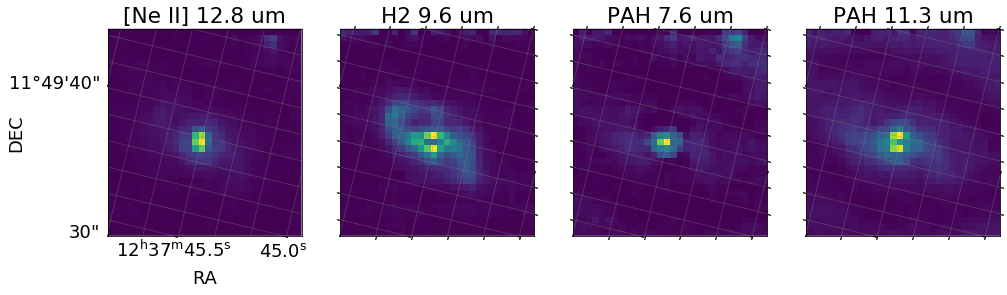

In [20]:
fig = plt.subplots(figsize=(16,4))
ax1 = plt.subplot(141, projection=wcs_cube)
ax2 = plt.subplot(142, projection=wcs_cube)
ax3 = plt.subplot(143, projection=wcs_cube)
ax4 = plt.subplot(144, projection=wcs_cube)
ax1.grid(color='grey', alpha=0.4, ls='solid')
ax2.grid(color='grey', alpha=0.4, ls='solid')
ax3.grid(color='grey', alpha=0.4, ls='solid')
ax4.grid(color='grey', alpha=0.4, ls='solid')
ra = ax1.coords['ra']
dec = ax1.coords['dec']
ra.set_ticks(number=10, exclude_overlapping=True)
dec.set_ticks(number=10, exclude_overlapping=True)
ra.set_axislabel('RA')
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
dec.set_axislabel('DEC', minpad=-0.4)

ra = ax2.coords['ra']
dec = ax2.coords['dec']
ra.set_ticks(number=10, exclude_overlapping=True)
dec.set_ticks(number=10, exclude_overlapping=True)
ra.set_ticklabel_visible(False)
dec.set_ticklabel_visible(False)

ra = ax3.coords['ra']
dec = ax3.coords['dec']
ra.set_ticks(number=10, exclude_overlapping=True)
dec.set_ticks(number=10, exclude_overlapping=True)
ra.set_ticklabel_visible(False)
dec.set_ticklabel_visible(False)

ra = ax4.coords['ra']
dec = ax4.coords['dec']
ra.set_ticks(number=10, exclude_overlapping=True)
dec.set_ticks(number=10, exclude_overlapping=True)
ra.set_ticklabel_visible(False)
dec.set_ticklabel_visible(False)


ax1.set_title('[Ne II] 12.8 um')
ax1.imshow(np.rot90(necube_flux, k=1), origin='lower')
ax2.set_title('H2 9.6 um')
ax2.imshow(np.rot90(h2cube_flux, k=1), origin='lower')
ax3.set_title('PAH 7.6 um')
ax3.imshow(np.rot90(pahcube_ion_flux, k=1), origin='lower')
ax4.set_title('PAH 11.3 um')
ax4.imshow(np.rot90(pahcube_neutral_flux, k=1), origin='lower')
           
plt.show()

## IONS

In [21]:
#Extract all the Ionic Lines

FeII_mapflux=np.zeros((ysize, zsize))
ArII_mapflux=np.zeros((ysize, zsize))
ArIII_mapflux=np.zeros((ysize, zsize))
SIV_mapflux=np.zeros((ysize, zsize))
NeII_mapflux=np.zeros((ysize, zsize))
ClII_mapflux=np.zeros((ysize, zsize))


line='FeII'
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        FeII_mapflux[pos]=0.0
    else:
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        FeII_mapflux[pos]=lflux

line='ArII'
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        ArII_mapflux[pos]=0.0
    else:
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        ArII_mapflux[pos]=lflux

line='ArIII'
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        ArIII_mapflux[pos]=0.0
    else:
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        ArIII_mapflux[pos]=lflux

line='SIV'
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        SIV_mapflux[pos]=0.0
    else:
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        SIV_mapflux[pos]=lflux

line='NeII'
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        NeII_mapflux[pos]=0.0
    else:
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        NeII_mapflux[pos]=lflux
        
line='ClII'
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        ClII_mapflux[pos]=0.0
    else:
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        ClII_mapflux[pos]=lflux

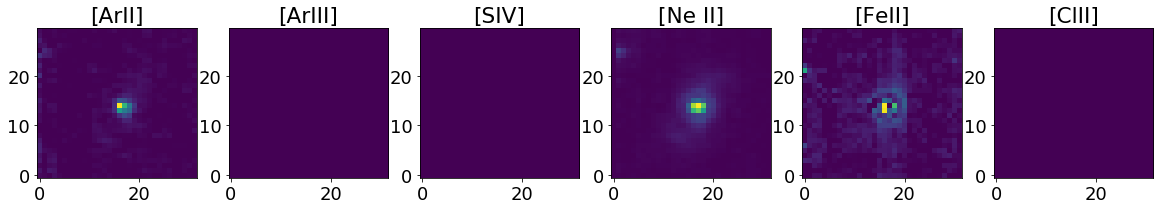

In [22]:
#Plot alls in pixel axis

f,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(1,6, figsize=(20,20))

ax1.set_title('[ArII]')
ax1.imshow(ArII_mapflux, origin='lower')
ax2.set_title('[ArIII]')
ax2.imshow(ArIII_mapflux, origin='lower')
ax3.set_title('[SIV]')
ax3.imshow(SIV_mapflux, origin='lower')
ax4.set_title('[Ne II]')
ax4.imshow(NeII_mapflux, origin='lower')
ax5.set_title('[FeII]')
ax5.imshow(FeII_mapflux, origin='lower')
ax6.set_title('[ClII]')
ax6.imshow(ClII_mapflux, origin='lower')

plt.show()

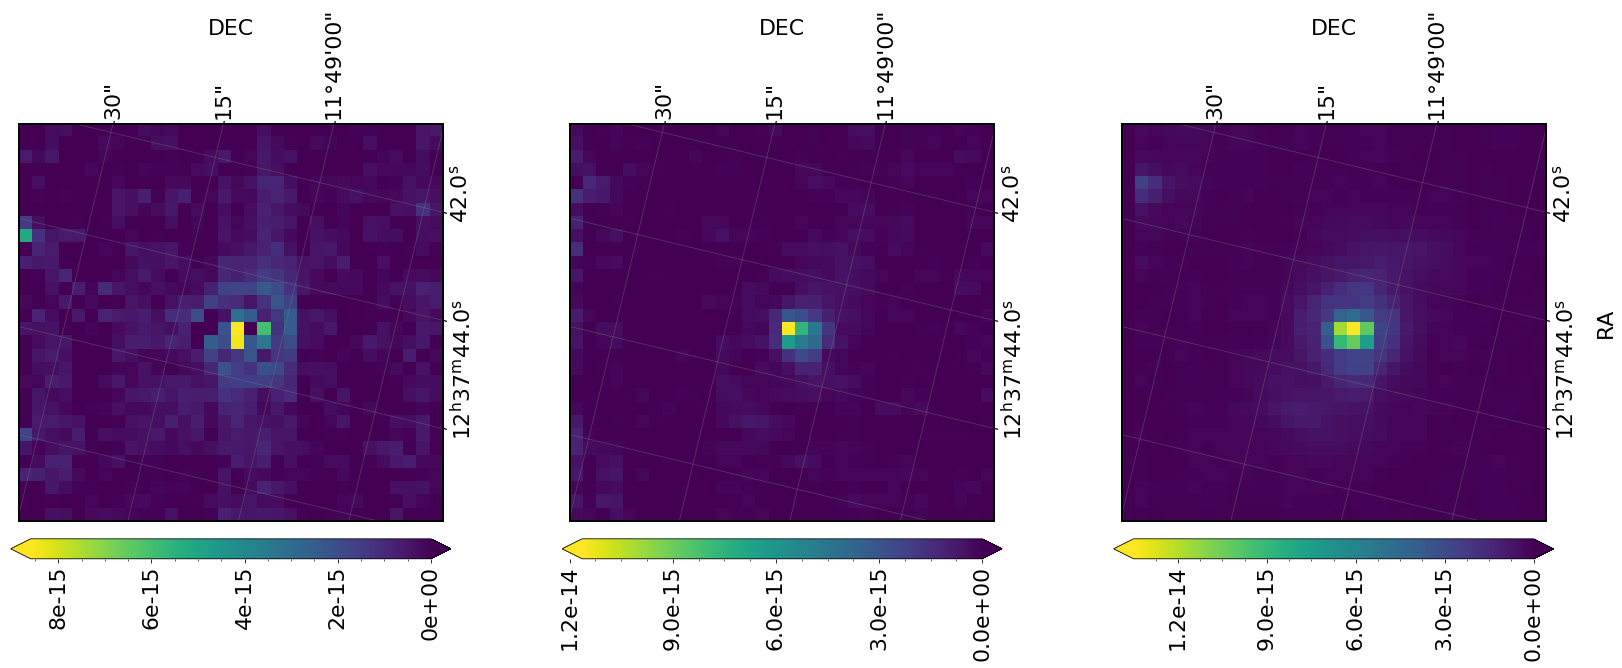

In [23]:
#Plot only the relevants with WCS (figure rotated to obtain the RA values in the most spreaded axis)

from matplotlib.ticker import MultipleLocator

plt.rcParams.update({'font.size': 22})

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(28, 8), ncols=3)
#fig.suptitle(r"Emisión de Iones [erg s$^{-1}$ cm$^{-2}$]", fontsize=26)

ax1 = plt.subplot(131, projection=wcs_cube)
ax2 = plt.subplot(132, projection=wcs_cube)
ax3 = plt.subplot(133, projection=wcs_cube)
#ax4 = plt.subplot(144, projection=wcs_cube)
ax1.grid(color='grey', alpha=0.4, ls='solid')
ax2.grid(color='grey', alpha=0.4, ls='solid')
ax3.grid(color='grey', alpha=0.4, ls='solid')
#ax4.grid(color='grey', alpha=0.4, ls='solid')
ra = ax1.coords['ra']
dec = ax1.coords['dec']

dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
#ra.set_axislabel('RA', minpad=-26)
dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
#ra.set_axislabel('RA', minpad=-24)

ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax1.coords.frame.set_linewidth(2)

ra = ax2.coords['ra']
dec = ax2.coords['dec']
dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
#ra.set_axislabel('RA', minpad=-26)
dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
#ra.set_axislabel('RA', minpad=-22)

dec.set_major_formatter('dd:mm:ss')
ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax2.coords.frame.set_linewidth(2)

ra = ax3.coords['ra']
dec = ax3.coords['dec']
dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_axislabel('RA', minpad=-22)

dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax3.coords.frame.set_linewidth(2)

#ra = ax4.coords['ra']
#dec = ax4.coords['dec']
#ra.set_ticks(number=5, exclude_overlapping=True)
#dec.set_ticks(number=10, exclude_overlapping=True)
#ra.set_ticklabel_visible(False)
#dec.set_ticklabel_visible(False)

#ax1.set_title('[ArII] 6.98 μm')
#ax2.set_title('[ArIII] 8.9 μm')
#ax3.set_title('[SIV] 10.51 μm')
#ax4.set_title('[Ne II] 12.8 μm')

#ax1.set_title('[Fe II] 5.34 μm')
#ax2.set_title('[Ar II] 6.98 μm')
#ax3.set_title('[Ne II] 12.8 μm')
#ax4.set_title('[Ne II] 12.8 μm')
pos1 = ax1.imshow(FeII_mapflux, origin='lower')
#pos2 = ax2.imshow(np.rot90(ArIII_mapflux, k=1), origin='lower')
pos2 = ax2.imshow(ArII_mapflux, origin='lower')
pos3 = ax3.imshow(NeII_mapflux, origin='lower')
#pos4 = ax4.imshow(np.rot90(NeII_mapflux, k=1), origin='lower')
           
cbar = fig.colorbar(pos1, ax=ax1, extend='both', orientation="horizontal", fraction=0.046, pad=0.04, format='%1.e')
#from matplotlib.ticker import MultipleLocator
cbar.locator = MultipleLocator(2e-15) # Show ticks only for each multiple of 1
cbar.update_ticks()
cbar.minorticks_on()
plt.setp(cbar.ax.get_xticklabels(),rotation=90)
cbar.ax.invert_xaxis()
#plt.setp(cbar.ax.get_xscale(),rotation=90)

cbar = fig.colorbar(pos2, ax=ax2, extend='both', orientation="horizontal" , fraction=0.046, pad=0.04, format='%1.1e')
cbar.locator = MultipleLocator(3e-15) # Show ticks only for each multiple of 1
cbar.update_ticks()
cbar.minorticks_on()
plt.setp(cbar.ax.get_xticklabels(),rotation=90)
cbar.ax.invert_xaxis()
cbar = fig.colorbar(pos3, ax=ax3, extend='both', orientation="horizontal" , fraction=0.046, pad=0.04, format='%1.1e')
cbar.locator = MultipleLocator(3e-15) # Show ticks only for each multiple of 1
cbar.update_ticks()
cbar.minorticks_on()
plt.setp(cbar.ax.get_xticklabels(),rotation=90)
cbar.ax.invert_xaxis()
#cbar = fig.colorbar(pos4, ax=ax4, extend='both', fraction=0.046, pad=0.04)
#cbar.minorticks_on()

#plt.savefig('/home/ivan/Documentos/Imagen_Tesis/mapa_ion.png', bbox_inches='tight', dpi=300)  
plt.show()

## Molecular Hydrogen

In [24]:
#All lines

H2_55_mapflux=np.zeros((ysize, zsize))
H2_61_mapflux=np.zeros((ysize, zsize))
H2_69_mapflux=np.zeros((ysize, zsize))
H2_80_mapflux=np.zeros((ysize, zsize))
H2_96_mapflux=np.zeros((ysize, zsize))
H2_122_mapflux=np.zeros((ysize, zsize))


line='55'
i=0
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        H2_55_mapflux[pos]=float('nan')
    else:
        lflux=0.
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = 'h'+line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        H2_55_mapflux[pos]=lflux
        
line='61'
i=0
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        H2_61_mapflux[pos]=float('nan')
    else:
        lflux=0.
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = 'h'+line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        H2_61_mapflux[pos]=lflux
        
line='69'
i=0
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        H2_69_mapflux[pos]=float('nan')
    else:
        lflux=0.
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = 'h'+line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        H2_69_mapflux[pos]=lflux
        
line='80'
i=0
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        H2_80_mapflux[pos]=float('nan')
    else:
        lflux=0.
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = 'h'+line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        H2_80_mapflux[pos]=lflux
        
line='96'
i=0
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        H2_96_mapflux[pos]=float('nan')
    else:
        lflux=0.
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = 'h'+line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        H2_96_mapflux[pos]=lflux
        
line='122'
i=0
for pos, dumpval in cube_res.items():
    if str(cube_res[pos])=='nan':
        H2_122_mapflux[pos]=float('nan')
    else:
        lflux=0.
        result = modres.loads(dumpval, funcdefs=funcdefs)
        prefix = 'h'+line+'_'
        amp, cen, std = gaussian_extractpars(prefix,result)               
        lflux= gaussianline_flux(amp,std,cen)                      
        H2_122_mapflux[pos]=lflux

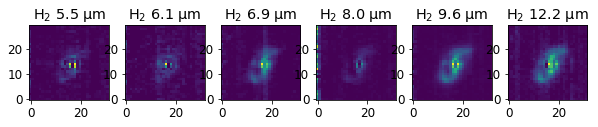

In [25]:
#Plot every lines in pixel axis
plt.rcParams.update({'font.size': 12})

f,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(1,6, figsize=(10,15))

ax1.set_title(r"H$_2$ 5.5 μm")
ax2.set_title(r"H$_2$ 6.1 μm")
ax3.set_title(r"H$_2$ 6.9 μm")
ax4.set_title(r"H$_2$ 8.0 μm")
ax5.set_title(r"H$_2$ 9.6 μm")
ax6.set_title(r"H$_2$ 12.2 μm")

ax1.imshow(H2_55_mapflux, origin='lower')
ax2.imshow(H2_61_mapflux, origin='lower')
ax3.imshow(H2_69_mapflux, origin='lower')
ax4.imshow(H2_80_mapflux, origin='lower')
ax5.imshow(H2_96_mapflux, origin='lower')
ax6.imshow(H2_122_mapflux, origin='lower')
           
plt.show()

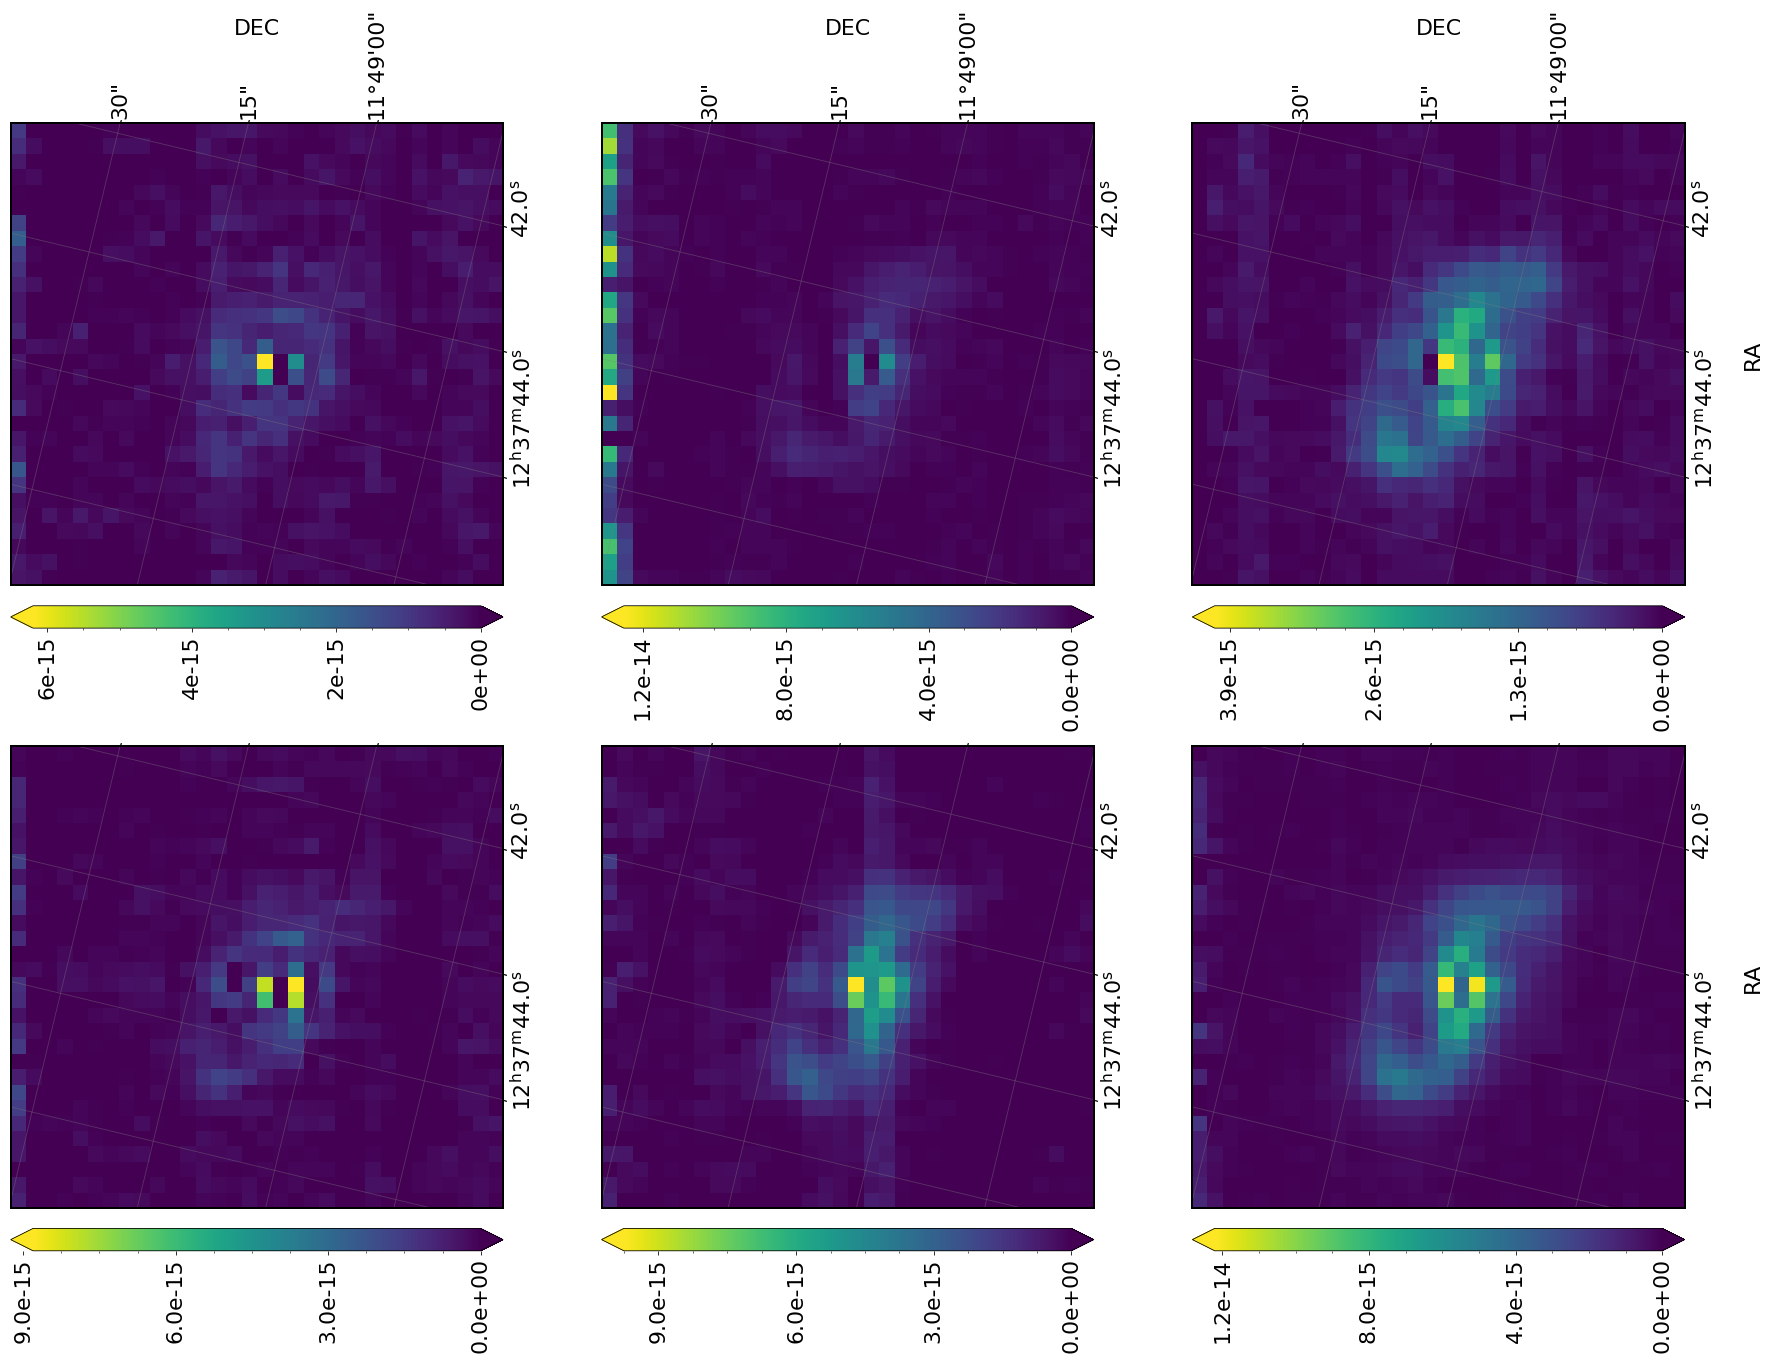

In [26]:
#Plot all with WCS (figure rotated to obtain the RA values in the most spreaded axis)
plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(figsize=(30, 21), ncols=3, nrows=2)
#fig.suptitle(r"Emisión de H$_2$ [erg s$^{-1}$ cm$^{-2}$]", fontsize=26)

ax1 = plt.subplot(231, projection=wcs_cube)
ax2 = plt.subplot(232, projection=wcs_cube)
ax3 = plt.subplot(233, projection=wcs_cube)
ax4 = plt.subplot(234, projection=wcs_cube)
ax5 = plt.subplot(235, projection=wcs_cube)
ax6 = plt.subplot(236, projection=wcs_cube)
ax1.grid(color='grey', alpha=0.4, ls='solid')
ax2.grid(color='grey', alpha=0.4, ls='solid')
ax3.grid(color='grey', alpha=0.4, ls='solid')
ax4.grid(color='grey', alpha=0.4, ls='solid')
ax5.grid(color='grey', alpha=0.4, ls='solid')
ax6.grid(color='grey', alpha=0.4, ls='solid')
ra = ax1.coords['ra']
dec = ax1.coords['dec']

dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
#ra.set_axislabel('RA', minpad=-26)
dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
#ra.set_axislabel('RA', minpad=-24)
ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax1.coords.frame.set_linewidth(2)


ra = ax2.coords['ra']
dec = ax2.coords['dec']
dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
#ra.set_axislabel('RA', minpad=-26)
dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
#ra.set_axislabel('RA', minpad=-24)
ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax2.coords.frame.set_linewidth(2)

ra = ax3.coords['ra']
dec = ax3.coords['dec']
dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
#ra.set_axislabel('RA', minpad=-26)
dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
ra.set_axislabel('RA', minpad=-25.5)
ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax3.coords.frame.set_linewidth(2)

ra = ax4.coords['ra']
dec = ax4.coords['dec']
dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
#ra.set_axislabel('RA', minpad=-26)
dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
#ra.set_axislabel('RA', minpad=-24)
ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax4.coords.frame.set_linewidth(2)
dec.set_ticklabel_visible(False)

ra = ax5.coords['ra']
dec = ax5.coords['dec']
dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
#ra.set_axislabel('RA', minpad=-26)
dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
#ra.set_axislabel('RA', minpad=-24)
ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax5.coords.frame.set_linewidth(2)
dec.set_ticklabel_visible(False)

ra = ax6.coords['ra']
dec = ax6.coords['dec']
dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
#ra.set_axislabel('RA', minpad=-26)
dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
ra.set_axislabel('RA', minpad=-25.5)
ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax6.coords.frame.set_linewidth(2)
dec.set_ticklabel_visible(False)

#ax1.set_title(r"H$_2$ 5.5 μm")
#ax2.set_title(r"H$_2$ 6.1 μm")
#ax3.set_title(r"H$_2$ 6.9 μm")
#ax4.set_title(r"H$_2$ 8.0 μm")
#ax5.set_title(r"H$_2$ 9.6 μm")
#ax6.set_title(r"H$_2$ 12.2 μm")
pos4 = ax4.imshow(H2_55_mapflux, origin='lower')
pos1 = ax1.imshow(H2_61_mapflux, origin='lower')
pos5 = ax5.imshow(H2_69_mapflux, origin='lower')
pos2 = ax2.imshow(H2_80_mapflux, origin='lower')
pos6 = ax6.imshow(H2_96_mapflux, origin='lower')
pos3 = ax3.imshow(H2_122_mapflux, origin='lower')
          

cbar = fig.colorbar(pos1, ax=ax1, extend='both', orientation="horizontal", fraction=0.046, pad=0.04, format='%1.e')
cbar.locator = MultipleLocator(2e-15) # Show ticks only for each multiple of 1
cbar.update_ticks()
cbar.minorticks_on()
plt.setp(cbar.ax.get_xticklabels(),rotation=90)
cbar.ax.invert_xaxis()
#plt.setp(cbar.ax.get_xscale(),rotation=90)

cbar = fig.colorbar(pos2, ax=ax2, extend='both', orientation="horizontal" , fraction=0.046, pad=0.04, format='%1.1e')
cbar.locator = MultipleLocator(4e-15) # Show ticks only for each multiple of 1
cbar.update_ticks()
cbar.minorticks_on()
plt.setp(cbar.ax.get_xticklabels(),rotation=90)
cbar.ax.invert_xaxis()

cbar = fig.colorbar(pos3, ax=ax3, extend='both', orientation="horizontal" , fraction=0.046, pad=0.04, format='%1.1e')
cbar.locator = MultipleLocator(1.3e-15) # Show ticks only for each multiple of 1
cbar.update_ticks()
cbar.minorticks_on()
plt.setp(cbar.ax.get_xticklabels(),rotation=90)
cbar.ax.invert_xaxis()

cbar = fig.colorbar(pos4, ax=ax4, extend='both', orientation="horizontal" , fraction=0.046, pad=0.04, format='%1.1e')
cbar.locator = MultipleLocator(3e-15) # Show ticks only for each multiple of 1
cbar.update_ticks()
cbar.minorticks_on()
plt.setp(cbar.ax.get_xticklabels(),rotation=90)
cbar.ax.invert_xaxis()

cbar = fig.colorbar(pos5, ax=ax5, extend='both', orientation="horizontal" , fraction=0.046, pad=0.04, format='%1.1e')
cbar.locator = MultipleLocator(3e-15) # Show ticks only for each multiple of 1
cbar.update_ticks()
cbar.minorticks_on()
plt.setp(cbar.ax.get_xticklabels(),rotation=90)
cbar.ax.invert_xaxis()

cbar = fig.colorbar(pos6, ax=ax6, extend='both', orientation="horizontal" , fraction=0.046, pad=0.04, format='%1.1e')
cbar.locator = MultipleLocator(4e-15) # Show ticks only for each multiple of 1
cbar.update_ticks()
cbar.minorticks_on()
plt.setp(cbar.ax.get_xticklabels(),rotation=90)
cbar.ax.invert_xaxis()

plt.savefig('/home/ivan/Documentos/Imagen_Tesis/mapa_h2.png', bbox_inches='tight', dpi=230)  
plt.show()

## PAHs (7.7 and 11.3 microns)

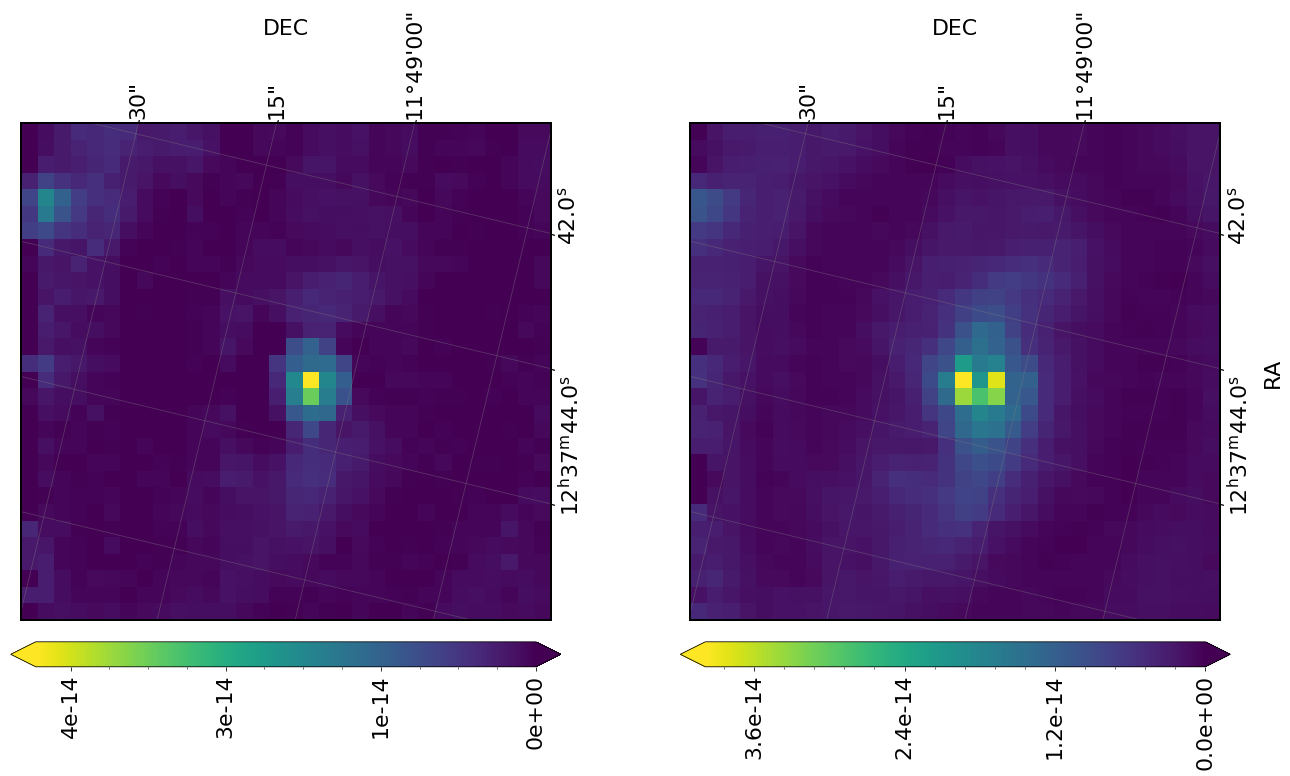

In [27]:
plt.rcParams.update({'font.size': 22})

fig, (ax1, ax2) = plt.subplots(figsize=(22, 10), ncols=2)
#fig.suptitle(r"Emisión de PAHs [erg s$^{-1}$ cm$^{-2}$]", fontsize=26)

ax1 = plt.subplot(121, projection=wcs_cube)
ax2 = plt.subplot(122, projection=wcs_cube)
ax1.grid(color='grey', alpha=0.4, ls='solid')
ax2.grid(color='grey', alpha=0.4, ls='solid')
ra = ax1.coords['ra']
dec = ax1.coords['dec']
dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
#ra.set_axislabel('RA', minpad=-26)
dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
#ra.set_axislabel('RA', minpad=-24)
ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax1.coords.frame.set_linewidth(2)

ra = ax2.coords['ra']
dec = ax2.coords['dec']
dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
#ra.set_axislabel('RA', minpad=-26)
dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
ra.set_axislabel('RA', minpad=-26.5)
ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax2.coords.frame.set_linewidth(2)

#ax1.set_title('PAH 7.6 μm')
#ax2.set_title('PAH 11.3 μm')

pos1 = ax1.imshow(pahcube_ion_flux, origin='lower')
pos2 = ax2.imshow(pahcube_neutral_flux, origin='lower')
          
    

cbar = fig.colorbar(pos1, ax=ax1, extend='both', orientation="horizontal", fraction=0.046, pad=0.04, format='%1.e')
cbar.locator = MultipleLocator(1.5e-14) # Show ticks only for each multiple of 1
cbar.update_ticks()
cbar.minorticks_on()
plt.setp(cbar.ax.get_xticklabels(),rotation=90)
cbar.ax.invert_xaxis()
#plt.setp(cbar.ax.get_xscale(),rotation=90)

cbar = fig.colorbar(pos2, ax=ax2, extend='both', orientation="horizontal" , fraction=0.046, pad=0.04, format='%1.1e')
cbar.locator = MultipleLocator(1.2e-14) # Show ticks only for each multiple of 1
cbar.update_ticks()
cbar.minorticks_on()
plt.setp(cbar.ax.get_xticklabels(),rotation=90)
cbar.ax.invert_xaxis()
    
plt.savefig('/home/ivan/Documentos/Imagen_Tesis/mapa_pah.png', bbox_inches='tight', dpi=300)  
#plt.show()

### RGB line and PAH feature flux maps.

In [28]:
#Using 21Mpc as reference for the distance (by RuizLapuente)
#9.86arcsec=1kpc
pix2kpc=5.482

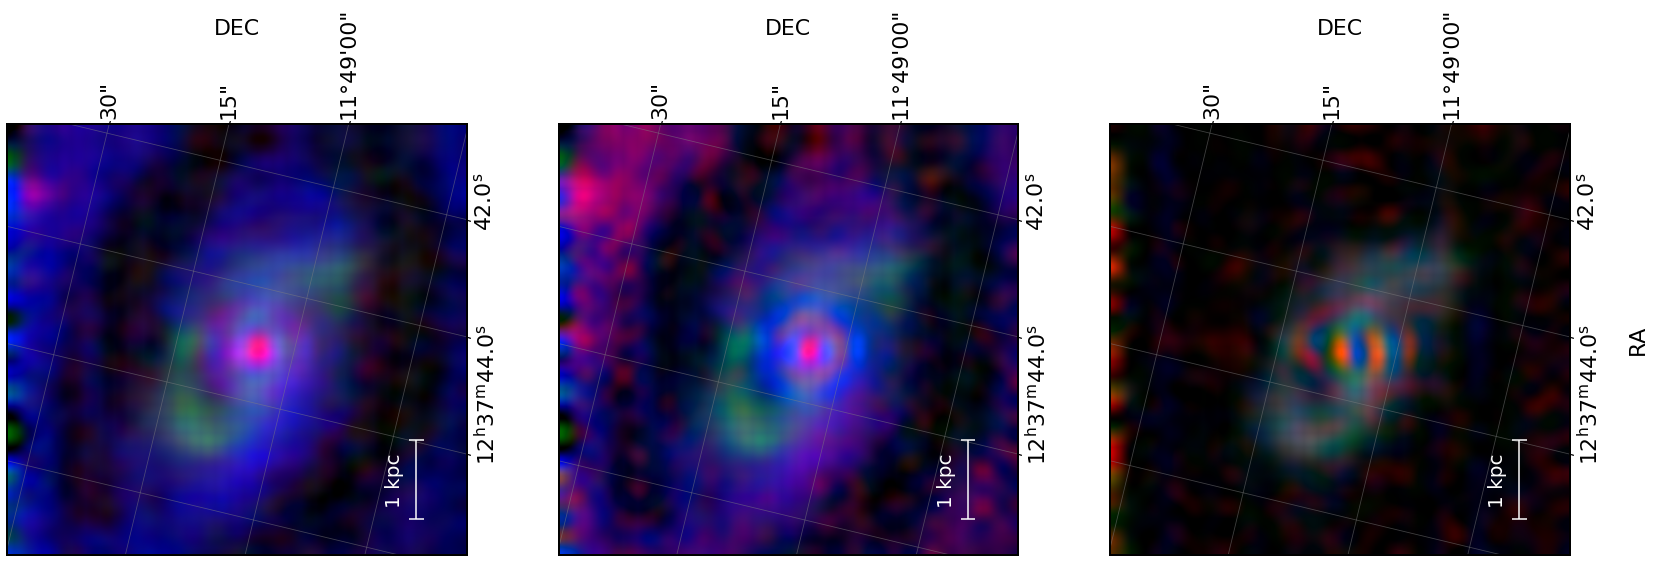

In [29]:
#m58_neii_pah0_h2 = make_lupton_rgb(2.5*necube_flux, h2cube_flux, pahcube_neutral_flux, minimum=0, Q=5, stretch=0.000000000000006, filename="m58_NeII_H96_PAH113.png")
#m58_pah_h2 = make_lupton_rgb(pahcube_neutral_flux, h2cube_flux, 1.2*pahcube_ion_flux, minimum=0, Q=5, stretch=0.000000000000006, filename="m58_PAH113_H96_PAH76.png")

m58_neii_pah0_h2 = make_lupton_rgb(necube_flux*2.7, h2cube_flux, pahcube_neutral_flux, minimum=1e-17, Q=9, stretch=4e-15, filename="m58_NeII_H96_PAH113.png")
m58_pah_h2 = make_lupton_rgb(pahcube_ion_flux*.7, h2cube_flux, pahcube_neutral_flux, minimum=1e-17, Q=9, stretch=4e-15, filename="m58_PAH113_H96_PAH76.png")
m58_h2_exc = make_lupton_rgb(H2_55_mapflux*1.5, H2_96_mapflux*.5, H2_122_mapflux*1.5, minimum=1e-17, Q=9, stretch=4e-15, filename="m58_PAH113_H96_PAH76.png")


plt.rcParams.update({'font.size': 22})
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(28, 8), ncols=3)
#fig.suptitle(r"Emisión de PAHs [erg s$^{-1}$ cm$^{-2}$]", fontsize=26)

ax1 = plt.subplot(131, projection=wcs_cube)
ax2 = plt.subplot(132, projection=wcs_cube)
ax3 = plt.subplot(133, projection=wcs_cube)
ax1.grid(color='grey', alpha=0.5, ls='solid')
ax2.grid(color='grey', alpha=0.5, ls='solid')
ax3.grid(color='grey', alpha=0.5, ls='solid')
ra = ax1.coords['ra']
dec = ax1.coords['dec']

dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
#ra.set_axislabel('RA', minpad=-26)
dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
#ra.set_axislabel('RA', minpad=-24)

ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax1.coords.frame.set_linewidth(2)

ra = ax2.coords['ra']
dec = ax2.coords['dec']
dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
#ra.set_axislabel('RA', minpad=-26)
dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
#ra.set_axislabel('RA', minpad=-22)

dec.set_major_formatter('dd:mm:ss')
ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax2.coords.frame.set_linewidth(2)

ra = ax3.coords['ra']
dec = ax3.coords['dec']
dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_axislabel('RA', minpad=-24)

dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax3.coords.frame.set_linewidth(2)

#ax1.set_title(r"[Ne II]-H$_2$S(3)-Neutral PAHs")
#ax2.set_title('PAH 11.3 μm')
#ax3.set_title('PAH 11.3 μm')

pos1 = ax1.imshow(m58_neii_pah0_h2, origin='lower',interpolation='sinc')
pos2 = ax2.imshow(m58_pah_h2, origin='lower',interpolation='sinc')
pos3 = ax3.imshow(m58_h2_exc, origin='lower',interpolation='sinc')


#ax1.hlines(3,3,3+pix2kpc,colors='w',linestyles='solid')
#ax1.vlines(3,3.5,2.5,colors='w',linestyles='solid')
#ax1.vlines(3+pix2kpc,3.5,2.5,colors='w',linestyles='solid')
#ax1.text((pix2kpc/2)+3,4,'1 kpc',fontsize=20,color='white',horizontalalignment='center')

ax1.vlines(28,2,2+pix2kpc,colors='w',linestyles='solid')
ax1.hlines(2,28.5,27.5,colors='w',linestyles='solid')
ax1.hlines(2+pix2kpc,28.5,27.5,colors='w',linestyles='solid')
ax1.text(26.5,pix2kpc,'1 kpc',fontsize=20,color='white',horizontalalignment='center', rotation=90)

ax2.vlines(28,2,2+pix2kpc,colors='w',linestyles='solid')
ax2.hlines(2,28.5,27.5,colors='w',linestyles='solid')
ax2.hlines(2+pix2kpc,28.5,27.5,colors='w',linestyles='solid')
ax2.text(26.5,pix2kpc,'1 kpc',fontsize=20,color='white',horizontalalignment='center', rotation=90)

ax3.vlines(28,2,2+pix2kpc,colors='w',linestyles='solid')
ax3.hlines(2,28.5,27.5,colors='w',linestyles='solid')
ax3.hlines(2+pix2kpc,28.5,27.5,colors='w',linestyles='solid')
ax3.text(26.5,pix2kpc,'1 kpc',fontsize=20,color='white',horizontalalignment='center', rotation=90)
    
plt.savefig('/home/ivan/Documentos/Imagen_Tesis/mapa_rgb.png', bbox_inches='tight', dpi=300)  
#plt.show()

3-color RGB images. Up: r = [Ne II] 12.8 micron, g = H2 S(3) 9.6 micron, b = PAH 11.3 micron. Ionized atomic gas in the active galactic nucleus shows up as red, shocked regions are green, and dust emission is blue. Medium: r = PAH 11.3 micron, g = H2 S(3) 9.6 micron, b = PAH 7.6 micron. Neutral PAH emission shows up as red, ionized PAH emission from PDRs in star-forming regions is blue, and shocked regions are green. Down: b = H2 S(7), g = H2 S(3), r = H2 S(2). All molecular emissions are contained in the same region.

## Extract and model cube sub-regions 
### Make spectral region masks 
Define spectral extraction regions based on spatial location, neighboors, line flux, and line or feature ratios.

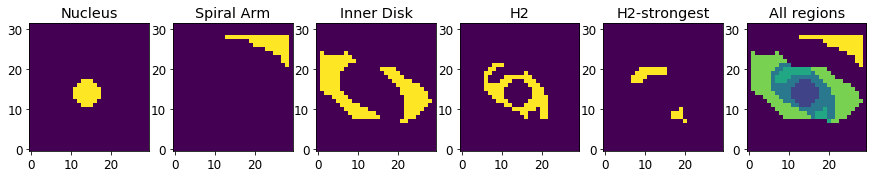

In [30]:
plt.rcParams.update({'font.size': 12})


#Nucleus extraction region, defined by 5 radius circle
nuc_mask=np.zeros((ysize, zsize))
for a in arange(-3,4):
    for b in arange(-3,4):
        if abs(a)+abs(b)<5:
            nuc_mask[14-a,17-b]=int(1)

#Spiral arm extraction region
arm_mask=np.where(((pahcube_neutral_flux>=0.155e-14) &((pahcube_ion_flux/pahcube_neutral_flux)>0.7) & (nuc_mask==0)),1,0)
arm_mask[:,:3]=int(0)  #Trim edges of cube
arm_mask[:,12:]=int(0)
arm_mask[0:10,:]=int(0)
#arm_mask[19,1]=int(1)
#arm_mask[18,2]=int(1)
arm_mask[ysize-1,:]=int(0)
arm_mask[:,zsize-1]=int(0) 



#for a in arange(1,ysize-1):
#    for b in arange(1,zsize-1):
#        suma=0
#        for ai in arange(-1,1):
#            for bi in arange(-1,1):
#                if ai=0 and bi=0:
#                    suma+=arm_mask[a+ai,b+bi]
        #if suma>

#Inner disk extraction region        
pah_mask=np.where(((pahcube_neutral_flux>=0.155e-14) & (h2cube_flux<1e-15) & (nuc_mask==0) & (arm_mask==0)),1,0)
pah_mask[:,0:7]=int(0) 
pah_mask[:,26:zsize]=int(0) 
pah_mask[0,:]=int(0) 
pah_mask[ysize-1,:]=int(0)
pah_mask[10,26]=int(1)
pah_mask[12,23]=int(1)

#Clean aislated pixels
for a in arange(1,ysize-1):
    for b in arange(1,zsize-1):
        suma=0
        for ai in [-1,0,1]:
            for bi in [-1,0,1]:
                if (ai!=0 or bi!=0):
                    suma+= pah_mask[a+ai,b+bi]
        #if suma>9:
            #pah_mask[a,b]=int(1)
        if suma==0:
            pah_mask[a,b]=int(0)


#Regions of strongest H2 emission
h2s_mask=np.where(((h2cube_flux>=1e-15)&((h2cube_flux/pahcube_neutral_flux)>0.7) & (nuc_mask==0)),1,0)
h2s_mask[:,0]=int(0) 


#H2 extraction region
h2_mask=np.where(((h2cube_flux>=1e-15) & (nuc_mask==0)),1,0)-h2s_mask
h2_mask[:,0]=int(0) 

#M58 combined central regions mask (excluding spiral arm)
m58_mask=nuc_mask + h2_mask*2 + h2s_mask*3 + pah_mask*4 +arm_mask*5

f,((ax1,ax2,ax3,ax4,ax5,ax6))=plt.subplots(1,6,figsize=(15,10))

ax1.set_title('Nucleus')
ax1.imshow(np.rot90(nuc_mask, k=1),origin='lower')
ax2.set_title('Spiral Arm')
ax2.imshow(np.rot90(arm_mask, k=1),origin='lower')
ax3.set_title('Inner Disk')
ax3.imshow(np.rot90(pah_mask, k=1),origin='lower')
ax4.set_title('H2')
ax4.imshow(np.rot90(h2_mask, k=1),origin='lower')
ax5.set_title('H2-strongest')
ax5.imshow(np.rot90(h2s_mask, k=1),origin='lower')
ax6.set_title('All regions')
ax6.imshow(np.rot90(m58_mask, k=1),origin='lower')

plt.show()

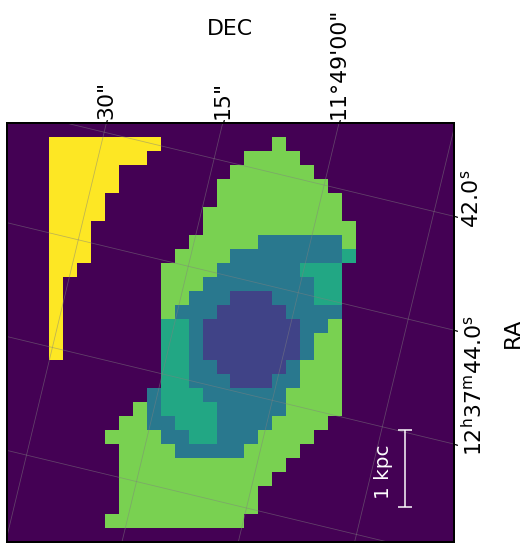

In [32]:
#Show all masks together
plt.rcParams.update({'font.size': 22})
#mpl.rc('axes', linewidth=0)

fig, ax1 = plt.subplots(figsize=(8, 8))
#fig.suptitle(r"Emisión de PAHs [erg s$^{-1}$ cm$^{-2}$]", fontsize=26)

ax1 = plt.subplot(111, projection=wcs_cube)
ax1.grid(color='grey', alpha=0.5, ls='solid')
ra = ax1.coords['ra']
dec = ax1.coords['dec']

dec.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)
ra.set_ticks(spacing=15 * u.arcsec, exclude_overlapping=True)


ra.set_axislabel('RA', minpad=-23)
dec.set_axislabel('DEC', minpad=-1)
ra.set_major_formatter('hh:mm:ss.s')
dec.set_major_formatter('dd:mm:ss')
#ra.display_minor_ticks(True)
#dec.display_minor_ticks(True)
#dec.set_minor_frequency(2)
#ra.set_minor_frequency(2)

ra.set_ticks_position('r')
ra.set_ticklabel_position('r')
ra.set_axislabel_position('l')
dec.set_ticks_position('t')
dec.set_ticklabel_position('t')
dec.set_axislabel_position('t')
#ra.set_

ra.set_ticklabel(rotation=90)
dec.set_ticklabel(rotation=90, pad=2 ,exclude_overlapping=True)
ax1.coords.frame.set_linewidth(2)

#ax1.set_title('Regiones de extracción')

pos1 = ax1.imshow(m58_mask, origin='lower')

ax1.vlines(28,2,2+pix2kpc,colors='w',linestyles='solid')
ax1.hlines(2,28.5,27.5,colors='w',linestyles='solid')
ax1.hlines(2+pix2kpc,28.5,27.5,colors='w',linestyles='solid')
ax1.text(26.5,pix2kpc,'1 kpc',fontsize=20,color='white',horizontalalignment='center', rotation=90)
plt.savefig('/home/ivan/Documentos/Imagen_Tesis/mapa_mascaras.png', bbox_inches='tight', dpi=300)  
    
#plt.show()

Extraction region masks based on spatial and emission line or PAH feature strengths.

### Extract spectra from mask regions

Spectra summed over five different regions: Spiral Arm, Nucleus, PAH, H2, and Strongest H2

In [33]:
def extract_spec(a,b):
    """extract spec and errors from a,b coordinates"""
    spec_pix=data_cube[:,a,b]
    err_pix=error_cube[:,a,b]
    return spec_pix, err_pix

nuc_spec=np.zeros(xsize,)
nuc_err=np.zeros(xsize,)
pah_spec=np.zeros(xsize,)
pah_err=np.zeros(xsize,)
h2_spec=np.zeros(xsize,)
h2_err=np.zeros(xsize,)
arm_spec=np.zeros(xsize,)
arm_err=np.zeros(xsize,)
h2s_spec=np.zeros(xsize,)
h2s_err=np.zeros(xsize,)
for a in arange(0,ysize):
    for b in arange(0,zsize):
        if nuc_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            nuc_spec=nuc_spec+spec_pix
            nuc_err=nuc_err+err_pix**2
        if pah_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            pah_spec=pah_spec+spec_pix
            pah_err=pah_err+err_pix**2
        if h2_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            h2_spec=h2_spec+spec_pix
            h2_err=h2_err+err_pix**2
        if arm_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            arm_spec=arm_spec+spec_pix
            arm_err=arm_err+err_pix**2
        if h2s_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            h2s_spec=h2s_spec+spec_pix
            h2s_err=h2s_err+err_pix**2

nuc_err=sqrt(nuc_err)
pah_err=sqrt(pah_err)
h2_err=sqrt(h2_err)
arm_err=sqrt(arm_err)
h2s_err=sqrt(h2s_err)

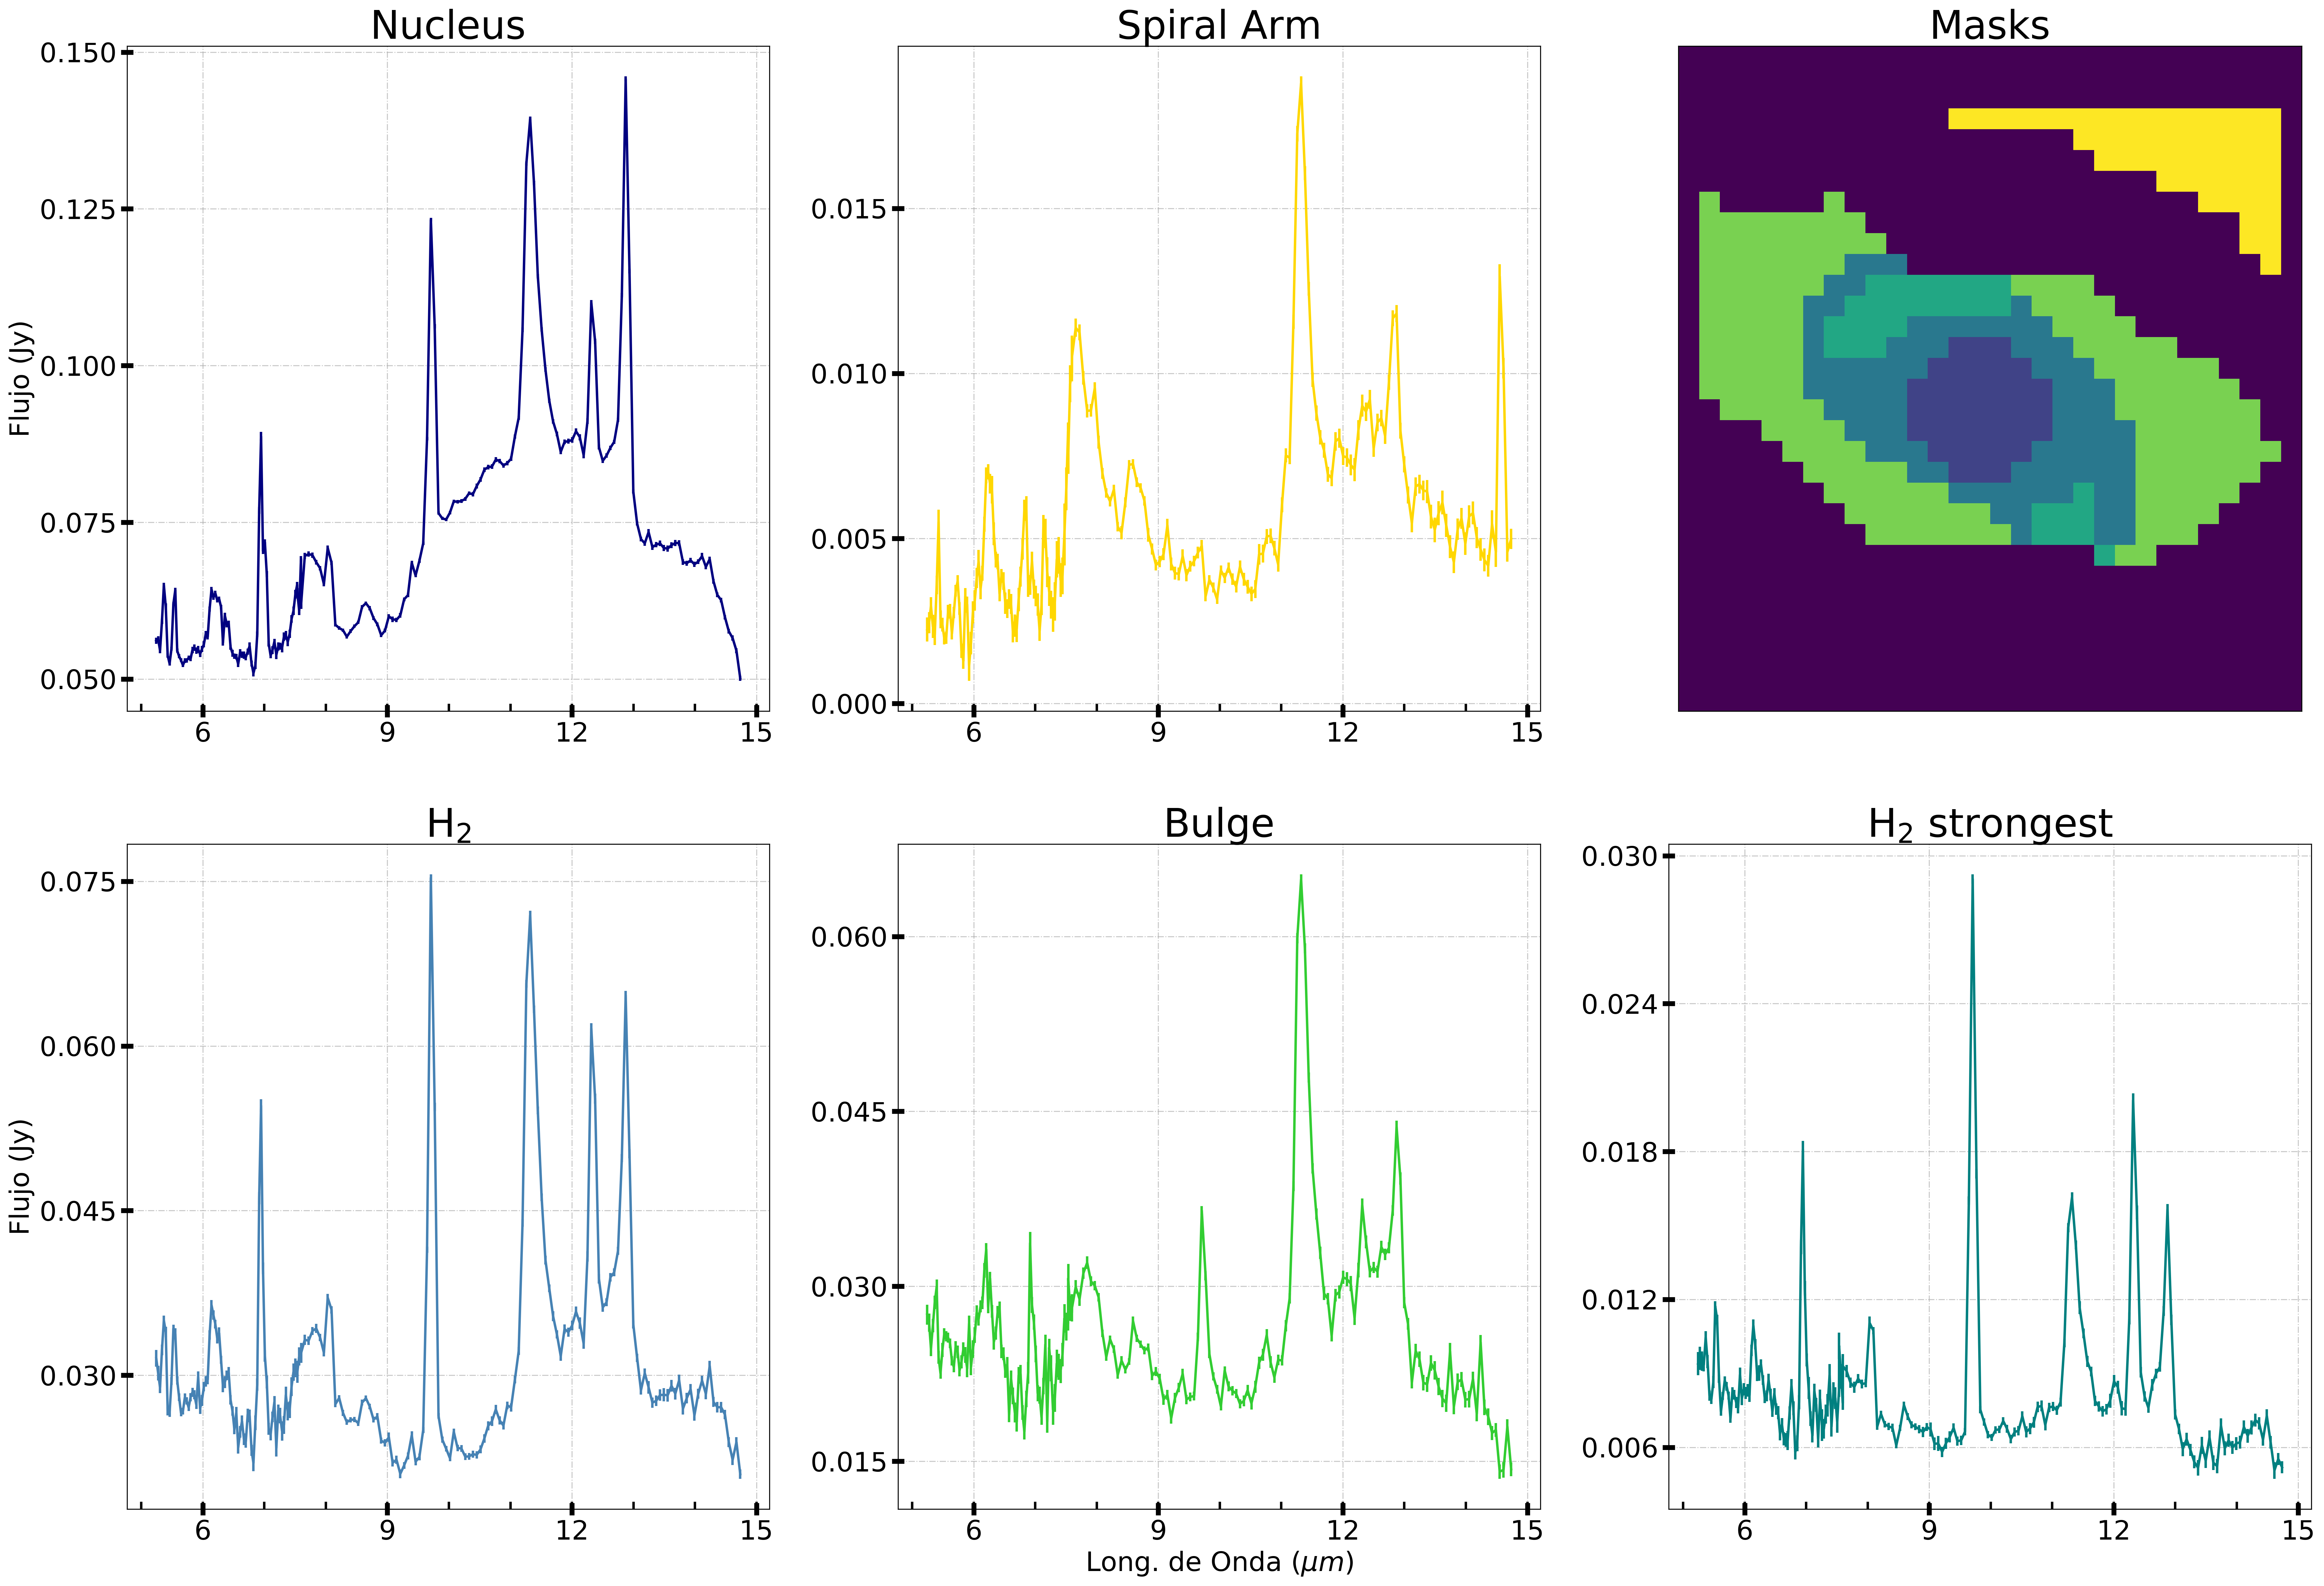

In [34]:
import matplotlib.ticker as ticker
########
def extract_spec(a,b):
    """extract spec and errors from a,b coordinates"""
    spec_pix=data_cube[:,a,b]
    err_pix=error_cube[:,a,b]
    return spec_pix, err_pix

nuc_spec=np.zeros(xsize,)
nuc_err=np.zeros(xsize,)
pah_spec=np.zeros(xsize,)
pah_err=np.zeros(xsize,)
h2_spec=np.zeros(xsize,)
h2_err=np.zeros(xsize,)
arm_spec=np.zeros(xsize,)
arm_err=np.zeros(xsize,)
h2s_spec=np.zeros(xsize,)
h2s_err=np.zeros(xsize,)
for a in arange(0,ysize):
    for b in arange(0,zsize):
        if nuc_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            nuc_spec=nuc_spec+spec_pix
            nuc_err=nuc_err+err_pix**2
        if pah_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            pah_spec=pah_spec+spec_pix
            pah_err=pah_err+err_pix**2
        if h2_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            h2_spec=h2_spec+spec_pix
            h2_err=h2_err+err_pix**2
        if arm_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            arm_spec=arm_spec+spec_pix
            arm_err=arm_err+err_pix**2
        if h2s_mask[a,b]==1:
            spec_pix,err_pix=extract_spec(a,b)
            h2s_spec=h2s_spec+spec_pix
            h2s_err=h2s_err+err_pix**2

nuc_err=sqrt(nuc_err)
pah_err=sqrt(pah_err)
h2_err=sqrt(h2_err)
arm_err=sqrt(arm_err)
h2s_err=sqrt(h2s_err)

#Figura
f,((ax1,ax2,ax3),(ax4,ax5,ax6))=plt.subplots(2,3,figsize=(32,22),dpi=300)

import matplotlib as mpl
#mpl.rcParams['axes.linewidth'] = 0.890 #set the value globally
mpl.rc('axes', linewidth=3.0)

SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 32

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#plt.rcParams["xtick.labelweight"] = "bold"
#plt.rcParams["axes.labelweight"] = "bold"

ax2.set_title('Spiral Arm')
ax2.errorbar(x,arm_spec,yerr=arm_err, c='gold', linewidth=2)
ax1.set_ylabel('Flujo (Jy)')

ax1.set_title('Nucleus')
ax1.errorbar(x,nuc_spec,yerr=nuc_err, c='navy', linewidth=2)
###############
    #Model Results
#fit_model = nuc_result.best_fit 
    #fit_residual = spec - fit_model

    #Evaluate model components
#comps = nuc_result.eval_components()
#plaw_model=comps['pwl_']
#h2_model=x-x
#h2comp=['h55_','h61_','h69_','h80_','h96_','h122_']
#for comp in h2comp:
#    h2_model+=comps[comp]
#ion_model=x-x
#atomiclines=['ArII','SIV','NeII']
#for comp in atomiclines:
#    ion_model+=comps[comp+'_']
#pahs_model=fit_model-plaw_model-h2_model-ion_model
#if silicates: 
#sidust_model=comps['sidust1_']
#pahs_model=pahs_model-sidust_model
        
    #Plot results
    #fig1=plt.figure(figsize=(15, 6), dpi= 150)
    #frame1=fig1.add_axes((.1,.3,.8,.6))
    #plt.errorbar(x, spec, yerr=specerr,label='Data', color='k')
    #plt.plot(x, fit_model,label='Model',c='red')
#if silicates: 
#ax1.plot(x,sidust_model,label='Si Dust', c='orange')
#ax1.plot(x, pahs_model,label='PAHs',c='magenta')
#ax1.plot(x, h2_model,label='H2',c='g')
#ax1.plot(x, ion_model,label='Ions',c='b')
    #plt.ylabel(r"$Flux\ (Jy)$")
    #plt.grid(linestyle=':')
    #plt.legend()
    #frame1.set_xticklabels([])
#####################
ax5.set_title('Bulge')
ax5.errorbar(x,pah_spec,yerr=pah_err, c='limegreen', linewidth=2)
ax5.set_xlabel(r"Wavelength $(\mu m)$")

ax4.set_title(r"H$_2$")
ax4.errorbar(x,h2_spec,yerr=h2_err, c='steelblue', linewidth=2)
#ax4.set_xlabel(r"Wavelength $(\mu m)$")
ax4.set_ylabel('Flujo (Jy)')


ax3.set_title('Masks')
ax3.imshow(np.rot90(m58_mask),origin='lower')
ax3.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelbottom=False, labelleft=False)
#ax3.set_xlabel('Pixel')

ax6.set_title(r"H$_2$ strongest")
ax6.errorbar(x,h2s_spec,yerr=h2s_err,c='teal', linewidth=2)
ax5.set_xlabel(r"Long. de Onda $(\mu m)$")

ax1.tick_params(which='major', width=4, length=10, direction='inout', grid_alpha=0.7)
ax1.tick_params(which='minor', width=2, length=6, direction='in')
ax2.tick_params(which='major', width=4, length=10, direction='inout', grid_alpha=0.7)
ax2.tick_params(which='minor', width=2, length=6, direction='in')
ax4.tick_params(which='major', width=4, length=10, direction='inout', grid_alpha=0.7)
ax4.tick_params(which='minor', width=2, length=6, direction='in')
ax5.tick_params(which='major', width=4, length=10, direction='inout', grid_alpha=0.7)
ax5.tick_params(which='minor', width=2, length=6, direction='in')
ax6.tick_params(which='major', width=4, length=10, direction='inout', grid_alpha=0.7)
ax6.tick_params(which='minor', width=2, length=6, direction='in')

ax1.grid(True, linestyle='-.')
ax2.grid(True, linestyle='-.')
ax4.grid(True, linestyle='-.')
ax5.grid(True, linestyle='-.')
ax6.grid(True, linestyle='-.')

ax1.xaxis.set_major_locator(ticker.MaxNLocator(4))
ax1.xaxis.set_minor_locator(ticker.MaxNLocator(12))
ax1.yaxis.set_major_locator(ticker.MaxNLocator(5))

ax2.xaxis.set_major_locator(ticker.MaxNLocator(4))
ax2.xaxis.set_minor_locator(ticker.MaxNLocator(12))
ax2.yaxis.set_major_locator(ticker.MaxNLocator(5))

ax4.xaxis.set_major_locator(ticker.MaxNLocator(4))
ax4.xaxis.set_minor_locator(ticker.MaxNLocator(12))
ax4.yaxis.set_major_locator(ticker.MaxNLocator(5))

ax5.xaxis.set_major_locator(ticker.MaxNLocator(4))
ax5.xaxis.set_minor_locator(ticker.MaxNLocator(12))
ax5.yaxis.set_major_locator(ticker.MaxNLocator(5))

ax6.xaxis.set_major_locator(ticker.MaxNLocator(4))
ax6.xaxis.set_minor_locator(ticker.MaxNLocator(12))
ax6.yaxis.set_major_locator(ticker.MaxNLocator(5))


plt.savefig('/home/ivan/Documentos/Imagen_Tesis/espectros_regiones.pdf', bbox_inches='tight', dpi=300)  
plt.show()

#savefig('demo.eps', transparent=True)


### Save spectra to files

In [35]:
#Save spec regions

np.savetxt(targname+'_spec_nuc.dat', np.column_stack((x, nuc_spec, nuc_err)),header='Wavelength[microns]     Flux_Nucleus[Jy]      Err_Flux_Nucleus')
np.savetxt(targname+'_spec_h2.dat', np.column_stack((x, h2_spec, h2_err)), header='Wavelength[microns]     Flux_H2[Jy]      Err_H2')
np.savetxt(targname+'_spec_h2s.dat', np.column_stack((x, h2_spec, h2_err)), header='Wavelength[microns]     Flux_H2s[Jy]      Err_H2s')
np.savetxt(targname+'_spec_pah.dat', np.column_stack((x, pah_spec, pah_err)), header='Wavelength[microns]     Flux_PAH[Jy]      Err_PAH')
np.savetxt(targname+'_spec_arm.dat', np.column_stack((x, arm_spec, arm_err)), header='Wavelength[microns]     Flux_Arm[Jy]      Err_Arm')

### Fit spectra of regions

In [36]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/home/ivan/soft/miniconda3/envs/astropy/lib/python3.5/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/ivan/soft/miniconda3/envs/astropy/lib/python3.5/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/ivan/soft/miniconda3/envs/astropy/lib/python3.5/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


#### Generic model components
Model 14 individual PAH components with all amplitudes free. It would be computationally expensive to do this
for the full cube, but only takes a couple of seconds for the summed region spectra.

In [37]:
#Power Law
p_law = Model(powerlaw,prefix='pwl_')
generic_pars = p_law.make_params()      #Generate the parameters
setpar(generic_pars,'pwl_c1',0.005,True,None)
setpar(generic_pars,'pwl_c2',0.0015,True,None)

#Individual PAHs
drudes=Model(Modelcero)
allpahlines=['52','62','74','76','78','83','86','112','113','119','126','134','140','141'] 
for line in allpahlines:
    prefix='PAH'+line+'_'  
    drudes+=Model(drude,prefix=prefix)  
generic_pars.update(drudes.make_params())

drude_defpar('PAH52', 5.27, 0.034, 0.05,generic_pars)
drude_defpar('PAH62', 6.22, 0.030, 0.05,generic_pars)
drude_defpar('PAH74', 7.42, 0.126, 0.05,generic_pars)
drude_defpar('PAH76', 7.60, 0.044, 0.05,generic_pars)
drude_defpar('PAH78', 7.85, 0.053, 0.5,generic_pars)
drude_defpar('PAH83', 8.33, 0.05, 0.5,generic_pars)
drude_defpar('PAH86', 8.61, 0.039, 0.5,generic_pars)
drude_defpar('PAH112', 11.23, 0.012, 0.5,generic_pars)
drude_defpar('PAH113', 11.33, 0.032, 0.5,generic_pars)
drude_defpar('PAH119', 11.99, 0.045, 0.5,generic_pars)
drude_defpar('PAH126', 12.62, 0.042, 0.5,generic_pars)
drude_defpar('PAH134', 13.48, 0.04, 0.5,generic_pars)
drude_defpar('PAH140', 14.04, 0.016, 0.5,generic_pars)
drude_defpar('PAH141', 14.19, 0.025, 0.5,generic_pars)

#Silicate dust emission
prefix='sidust1_'
silicate= Model(sidust,prefix=prefix)
generic_pars.update(silicate.make_params())
sidust_defpar('sidust1', 190.,1.E-4,generic_pars)

#Gaussians with FWHM and X central from Smith et al 2007
#H2 molecular
h2lines=['55','61','69','80','96','122']
gaussH2=Model(Modelcero)
for line in h2lines:
    prefix='h'+line+'_'
    gaussH2+=Model(gaussian,prefix=prefix)
generic_pars.update(gaussH2.make_params())
gaussian_defpar('h55',0.0005, 5.511, 0.053,generic_pars)
gaussian_defpar('h61',0.0005, 6.109, 0.053,generic_pars)
gaussian_defpar('h69',0.0005, 6.909, 0.053,generic_pars)
gaussian_defpar('h80',0.0005, 8.026, 0.100,generic_pars)
gaussian_defpar('h96',0.0005, 9.665, 0.100,generic_pars)
gaussian_defpar('h122',0.0005, 12.278, 0.100,generic_pars)

#Atomic lines
atomiclines=['FeII','ArII','ArIII','SIV','NeII','ClII']
gaussAt=Model(Modelcero)
for line in atomiclines:
    prefix = line+'_'
    gaussAt+=Model(gaussian,prefix=prefix)
generic_pars.update(gaussAt.make_params())
gaussian_defpar('FeII',0.0005, 5.34, 0.053,generic_pars)
gaussian_defpar('ArII',0.005, 6.985, 0.053,generic_pars)
gaussian_defpar('ArIII',0.0005, 8.991, 0.100,generic_pars)
gaussian_defpar('SIV',0.05, 10.511, 0.100,generic_pars)
gaussian_defpar('NeII',0.05, 12.813, 0.100,generic_pars)
gaussian_defpar('ClII',0.05, 14.37, 0.100,generic_pars)


#### Spiral arm spectral fit

Time count
--- 7.75369119644165 seconds ---
Chi square red= 12.77001329904416


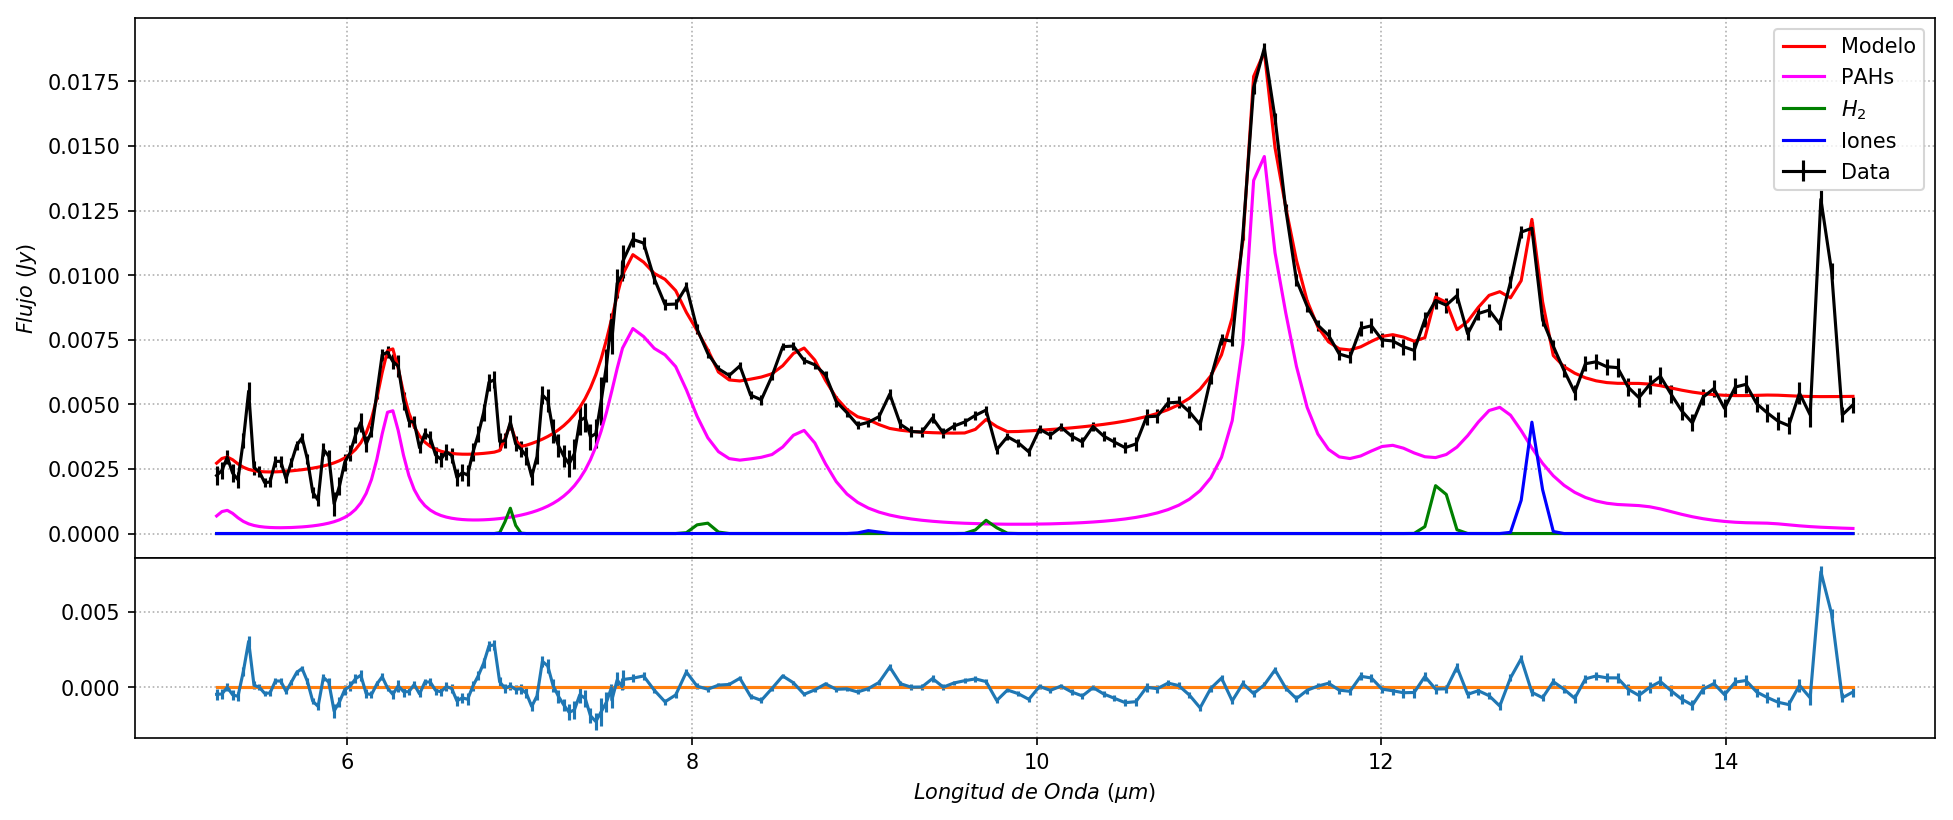

[[Model]]
    (((Model(powerlaw, prefix='pwl_') + ((((((((((((((Model(Modelcero) + Model(drude, prefix='PAH52_')) + Model(drude, prefix='PAH62_')) + Model(drude, prefix='PAH74_')) + Model(drude, prefix='PAH76_')) + Model(drude, prefix='PAH78_')) + Model(drude, prefix='PAH83_')) + Model(drude, prefix='PAH86_')) + Model(drude, prefix='PAH112_')) + Model(drude, prefix='PAH113_')) + Model(drude, prefix='PAH119_')) + Model(drude, prefix='PAH126_')) + Model(drude, prefix='PAH134_')) + Model(drude, prefix='PAH140_')) + Model(drude, prefix='PAH141_'))) + ((((((Model(Modelcero) + Model(gaussian, prefix='FeII_')) + Model(gaussian, prefix='ArII_')) + Model(gaussian, prefix='ArIII_')) + Model(gaussian, prefix='SIV_')) + Model(gaussian, prefix='NeII_')) + Model(gaussian, prefix='ClII_'))) + ((((((Model(Modelcero) + Model(gaussian, prefix='h55_')) + Model(gaussian, prefix='h61_')) + Model(gaussian, prefix='h69_')) + Model(gaussian, prefix='h80_')) + Model(gaussian, prefix='h96_')) + Model(gaussian, 

In [38]:
#Spiral arm spectrum
spec=arm_spec
specerr=arm_err

#Model (powerlaw + individual PAHs + H2 and Atomic lines, no extinction)
model = p_law + drudes + gaussAt + gaussH2

#Adjust power law starting parameters 
setpar(generic_pars,'pwl_c1',0.0001,True,None)
setpar(generic_pars,'pwl_c2',0.000001,True,None)

#Fit and plot
arm_result=fit_and_plot(spec,specerr,model,generic_pars,False)
print(arm_result.fit_report(show_correl=False))

Time count
--- 0.405118465423584 seconds ---
Chi square red= 12.041572106905345


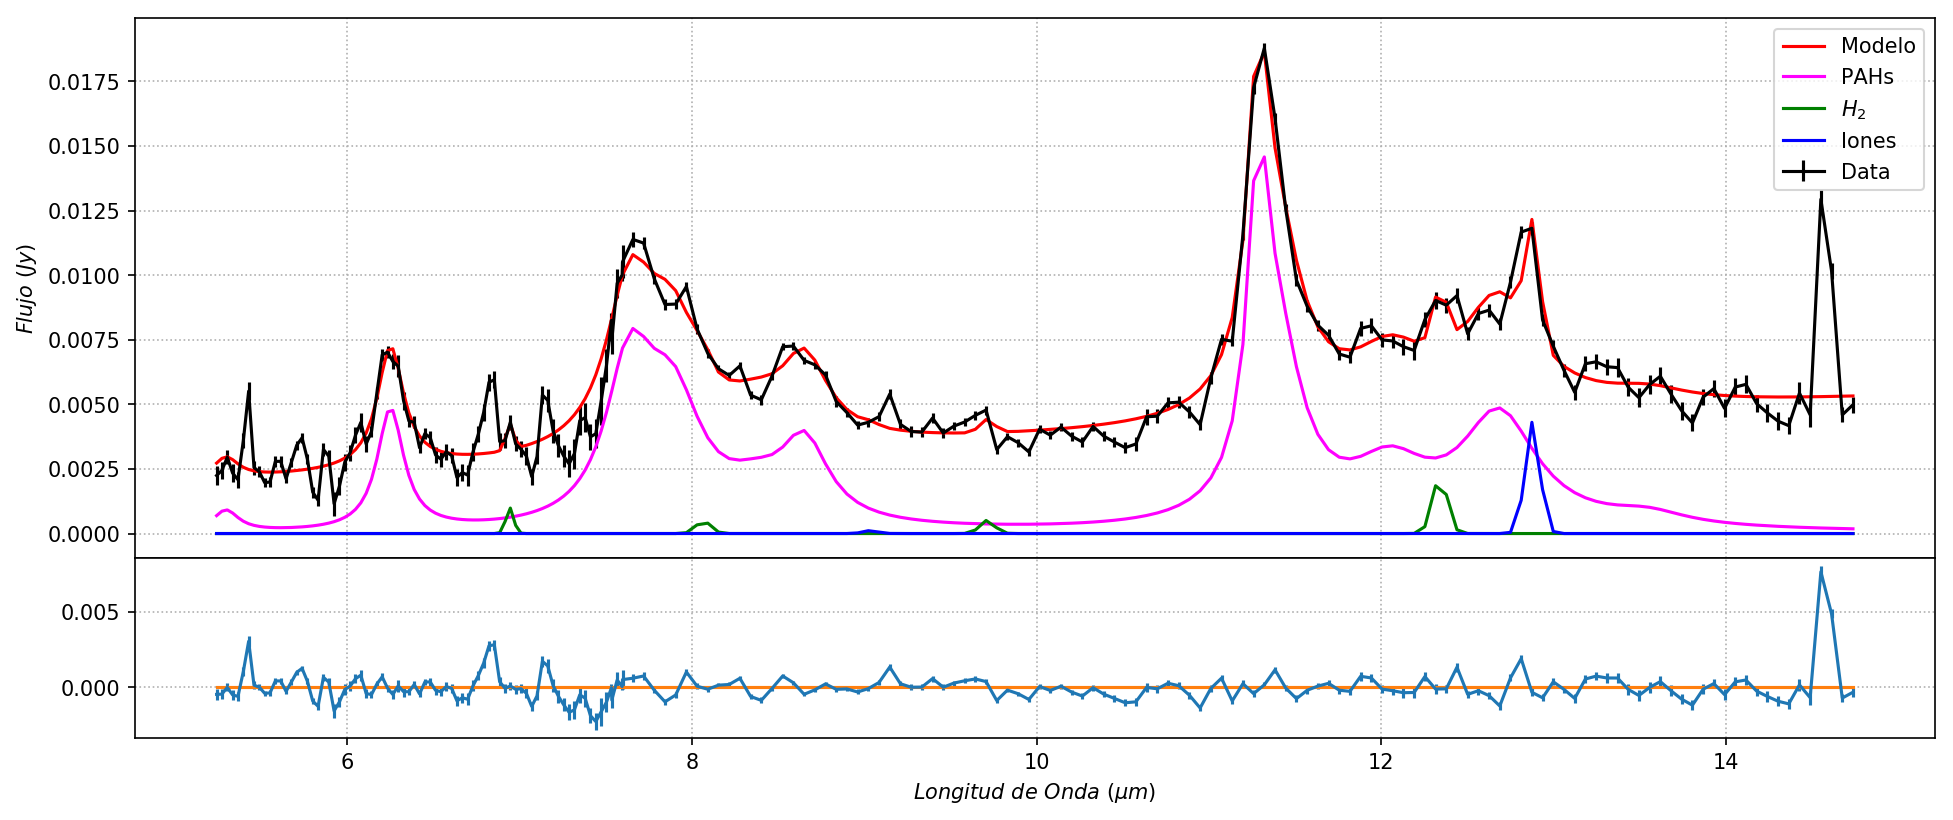

[[Model]]
    (((Model(powerlaw, prefix='pwl_') + ((((((((((((((Model(Modelcero) + Model(drude, prefix='PAH52_')) + Model(drude, prefix='PAH62_')) + Model(drude, prefix='PAH74_')) + Model(drude, prefix='PAH76_')) + Model(drude, prefix='PAH78_')) + Model(drude, prefix='PAH83_')) + Model(drude, prefix='PAH86_')) + Model(drude, prefix='PAH112_')) + Model(drude, prefix='PAH113_')) + Model(drude, prefix='PAH119_')) + Model(drude, prefix='PAH126_')) + Model(drude, prefix='PAH134_')) + Model(drude, prefix='PAH140_')) + Model(drude, prefix='PAH141_'))) + ((((((Model(Modelcero) + Model(gaussian, prefix='FeII_')) + Model(gaussian, prefix='ArII_')) + Model(gaussian, prefix='ArIII_')) + Model(gaussian, prefix='SIV_')) + Model(gaussian, prefix='NeII_')) + Model(gaussian, prefix='ClII_'))) + ((((((Model(Modelcero) + Model(gaussian, prefix='h55_')) + Model(gaussian, prefix='h61_')) + Model(gaussian, prefix='h69_')) + Model(gaussian, prefix='h80_')) + Model(gaussian, prefix='h96_')) + Model(gaussian, 

In [39]:
#Making parameters near 0 fixed, to obtain errors
for par in arm_result.params:
    value=arm_result.params[par].value
    vary=arm_result.params[par].vary
    minus=arm_result.params[par].min
    if minus==float("-inf"):
        minus=None
    generic_pars[par].set(value,vary=vary,min=minus)
    if value<=1e-4:
        value=0
        vary=False
        minus=None
    generic_pars[par].set(value,vary=vary,min=minus)
    
#Fit and plot
arm_result=fit_and_plot(spec,specerr,model,generic_pars,False)
print(arm_result.fit_report(show_correl=False))

Model fit to integrated spectrum of spiral arm region. 

#### H2 region spectral fit

In [40]:
#Generic Parameters
#Power Law
p_law = Model(powerlaw,prefix='pwl_')
generic_pars = p_law.make_params()      #Generate the parameters
setpar(generic_pars,'pwl_c1',0.05,True,None)
setpar(generic_pars,'pwl_c2',0.015,True,None)

#Individual PAHs
drudes=Model(Modelcero)
allpahlines=['52','62','74','76','78','83','86','112','113','119','126','134','140','141'] 
for line in allpahlines:
    prefix='PAH'+line+'_'  
    drudes+=Model(drude,prefix=prefix)  
generic_pars.update(drudes.make_params())

drude_defpar('PAH52', 5.27, 0.034, 0.00005,generic_pars)
drude_defpar('PAH62', 6.22, 0.030, 0.05,generic_pars)
drude_defpar('PAH74', 7.42, 0.126, 0.05,generic_pars)
drude_defpar('PAH76', 7.60, 0.044, 0.05,generic_pars)
drude_defpar('PAH78', 7.85, 0.053, 0.5,generic_pars)
drude_defpar('PAH83', 8.33, 0.05, 0.5,generic_pars)
drude_defpar('PAH86', 8.61, 0.039, 0.5,generic_pars)
drude_defpar('PAH112', 11.23, 0.012, 0.5,generic_pars)
drude_defpar('PAH113', 11.33, 0.032, 0.5,generic_pars)
drude_defpar('PAH119', 11.99, 0.045, 0.5,generic_pars)
drude_defpar('PAH126', 12.62, 0.042, 0.0005,generic_pars)
drude_defpar('PAH134', 13.48, 0.04, 0.5,generic_pars)
drude_defpar('PAH140', 14.04, 0.016, 0.5,generic_pars)
drude_defpar('PAH141', 14.19, 0.025, 0.5,generic_pars)

#Silicate dust emission
prefix='sidust1_'
silicate= Model(sidust,prefix=prefix)
generic_pars.update(silicate.make_params())
sidust_defpar('sidust1', 190.,1.E-4,generic_pars)

#Gaussians with FWHM and X central from Smith et al 2007
#H2 molecular
h2lines=['55','61','69','80','96','122']
gaussH2=Model(Modelcero)
for line in h2lines:
    prefix='h'+line+'_'
    gaussH2+=Model(gaussian,prefix=prefix)
generic_pars.update(gaussH2.make_params())
gaussian_defpar('h55',0.0005, 5.511, 0.053,generic_pars)
gaussian_defpar('h61',0.0005, 6.109, 0.053,generic_pars)
gaussian_defpar('h69',0.0005, 6.909, 0.053,generic_pars)
gaussian_defpar('h80',0.0005, 8.026, 0.100,generic_pars)
gaussian_defpar('h96',0.0005, 9.665, 0.100,generic_pars)
gaussian_defpar('h122',0.0005, 12.278, 0.100,generic_pars)

#Atomic lines
atomiclines=['FeII','ArII','ArIII','SIV','NeII','ClII']
gaussAt=Model(Modelcero)
for line in atomiclines:
    prefix = line+'_'
    gaussAt+=Model(gaussian,prefix=prefix)
generic_pars.update(gaussAt.make_params())
gaussian_defpar('FeII',0.5, 5.34, 0.053,generic_pars)
gaussian_defpar('ArII',0.005, 6.985, 0.053,generic_pars)
gaussian_defpar('ArIII',0.0005, 8.991, 0.100,generic_pars)
gaussian_defpar('SIV',0.05, 10.511, 0.100,generic_pars)
gaussian_defpar('NeII',0.05, 12.813, 0.100,generic_pars)
gaussian_defpar('ClII',0.05, 14.37, 0.100,generic_pars)


Time count
--- 7.000768184661865 seconds ---
Chi square red= 11.753331179025238


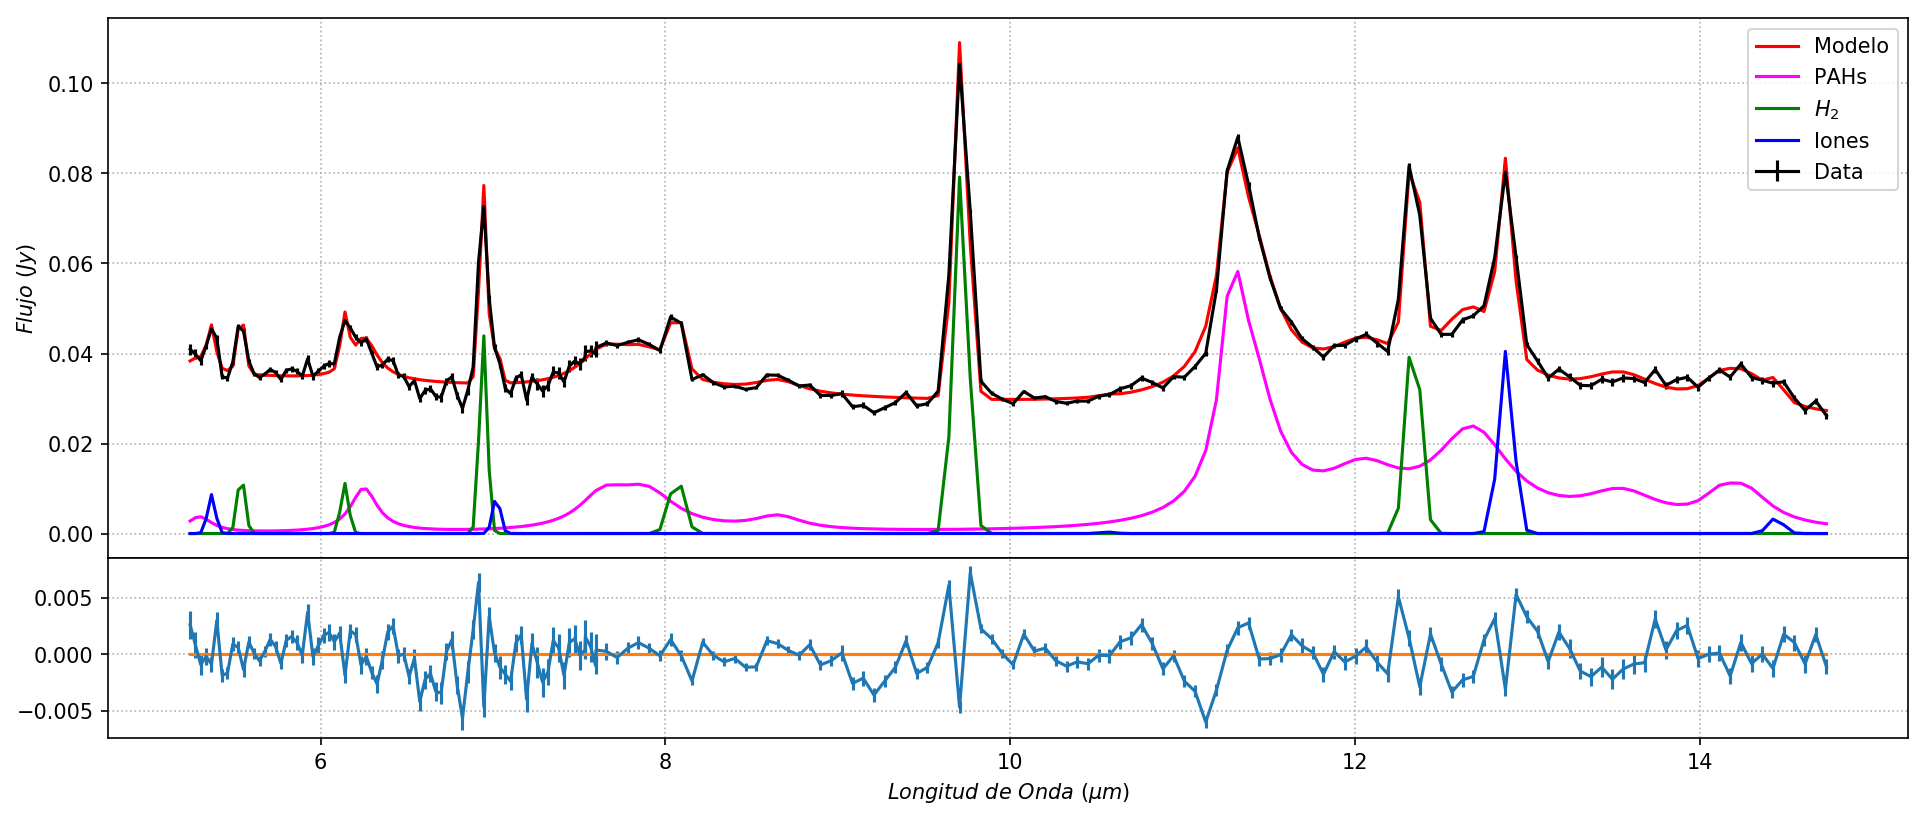

In [41]:
#H2 region spectrum
spec=h2s_spec+h2_spec
specerr=h2s_err+h2_err

#Model (powerlaw + individual PAHs + H2 and Atomic lines, no extinction)
model = p_law + drudes + gaussAt + gaussH2

#Adjust power law starting parameters 
setpar(generic_pars,'pwl_c1',0.002,True,None)
setpar(generic_pars,'pwl_c2',0.0015,True,None)

#Fit and plot
h2_result=fit_and_plot(spec,specerr,model,generic_pars,False)

Time count
--- 0.20640277862548828 seconds ---
Chi square red= 11.475145515111384


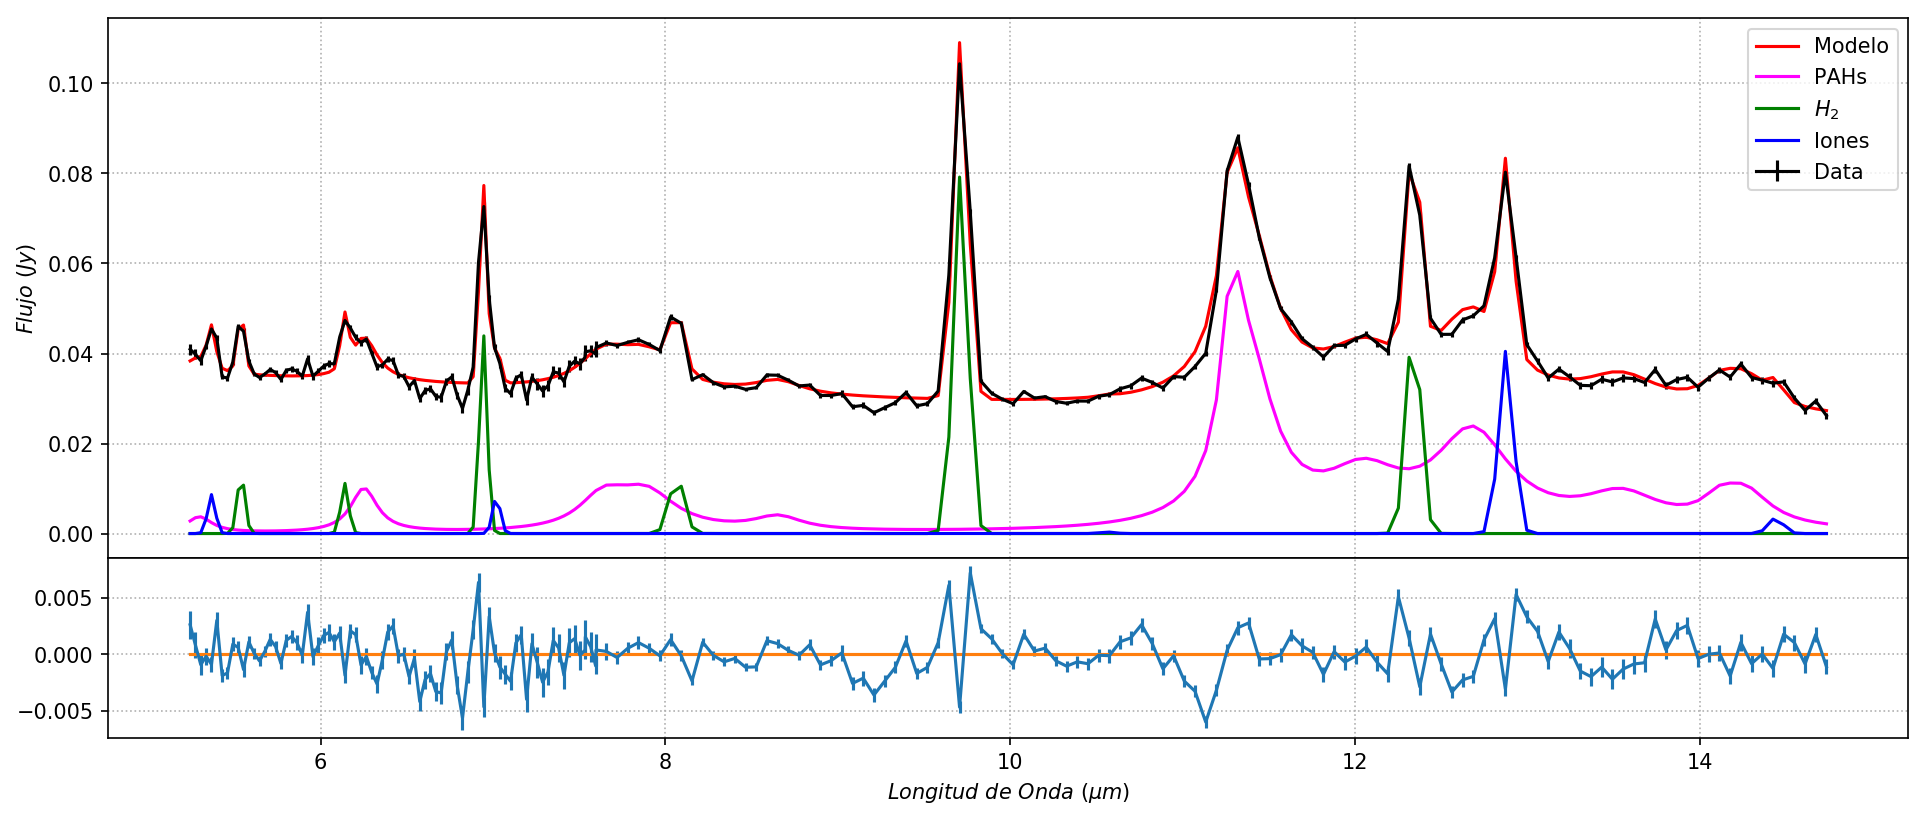

[[Model]]
    (((Model(powerlaw, prefix='pwl_') + ((((((((((((((Model(Modelcero) + Model(drude, prefix='PAH52_')) + Model(drude, prefix='PAH62_')) + Model(drude, prefix='PAH74_')) + Model(drude, prefix='PAH76_')) + Model(drude, prefix='PAH78_')) + Model(drude, prefix='PAH83_')) + Model(drude, prefix='PAH86_')) + Model(drude, prefix='PAH112_')) + Model(drude, prefix='PAH113_')) + Model(drude, prefix='PAH119_')) + Model(drude, prefix='PAH126_')) + Model(drude, prefix='PAH134_')) + Model(drude, prefix='PAH140_')) + Model(drude, prefix='PAH141_'))) + ((((((Model(Modelcero) + Model(gaussian, prefix='FeII_')) + Model(gaussian, prefix='ArII_')) + Model(gaussian, prefix='ArIII_')) + Model(gaussian, prefix='SIV_')) + Model(gaussian, prefix='NeII_')) + Model(gaussian, prefix='ClII_'))) + ((((((Model(Modelcero) + Model(gaussian, prefix='h55_')) + Model(gaussian, prefix='h61_')) + Model(gaussian, prefix='h69_')) + Model(gaussian, prefix='h80_')) + Model(gaussian, prefix='h96_')) + Model(gaussian, 

In [42]:
#Making parameters near 0 fixed, to obtain errors
for par in h2_result.params:
    value=h2_result.params[par].value
    vary=h2_result.params[par].vary
    minus=h2_result.params[par].min
    if minus==float("-inf"):
        minus=None
    generic_pars[par].set(value,vary=vary,min=minus)
    if abs(value)<=1e-4:
        value=0
        vary=False
        minus=None
    generic_pars[par].set(value,vary=vary,min=minus)
    
#Fit and plot
h2_result=fit_and_plot(spec,specerr,model,generic_pars,False)
print(h2_result.fit_report(show_correl=False))

Model fit to integrated spectrum of H2-strongest region. 

#### Nucleus spectral fit

In [43]:
#Generic Parameters
#Power Law
p_law = Model(powerlaw,prefix='pwl_')
generic_pars = p_law.make_params()      #Generate the parameters
setpar(generic_pars,'pwl_c1',0.05,True,None)
setpar(generic_pars,'pwl_c2',0.015,True,None)

#Individual PAHs
drudes=Model(Modelcero)
allpahlines=['52','62','74','76','78','83','86','112','113','119','126','134','140','141'] 
for line in allpahlines:
    prefix='PAH'+line+'_'  
    drudes+=Model(drude,prefix=prefix)  
generic_pars.update(drudes.make_params())

drude_defpar('PAH52', 5.27, 0.034, 0.00005,generic_pars)
drude_defpar('PAH62', 6.22, 0.030, 0.05,generic_pars)
drude_defpar('PAH74', 7.42, 0.126, 0.05,generic_pars)
drude_defpar('PAH76', 7.60, 0.044, 0.05,generic_pars)
drude_defpar('PAH78', 7.85, 0.053, 0.5,generic_pars)
drude_defpar('PAH83', 8.33, 0.05, 0.5,generic_pars)
drude_defpar('PAH86', 8.61, 0.039, 0.5,generic_pars)
drude_defpar('PAH112', 11.23, 0.012, 0.5,generic_pars)
drude_defpar('PAH113', 11.33, 0.032, 0.5,generic_pars)
drude_defpar('PAH119', 11.99, 0.045, 0.5,generic_pars)
drude_defpar('PAH126', 12.62, 0.042, 0.0005,generic_pars)
drude_defpar('PAH134', 13.48, 0.04, 0.5,generic_pars)
drude_defpar('PAH140', 14.04, 0.016, 0.5,generic_pars)
drude_defpar('PAH141', 14.19, 0.025, 0.5,generic_pars)

#Silicate dust emission
prefix='sidust1_'
silicate= Model(sidust,prefix=prefix)
generic_pars.update(silicate.make_params())
sidust_defpar('sidust1', 190.,1.E-4,generic_pars)

#Gaussians with FWHM and X central from Smith et al 2007
#H2 molecular
h2lines=['55','61','69','80','96','122']
gaussH2=Model(Modelcero)
for line in h2lines:
    prefix='h'+line+'_'
    gaussH2+=Model(gaussian,prefix=prefix)
generic_pars.update(gaussH2.make_params())
gaussian_defpar('h55',0.0005, 5.511, 0.053,generic_pars)
gaussian_defpar('h61',0.0005, 6.109, 0.053,generic_pars)
gaussian_defpar('h69',0.0005, 6.909, 0.053,generic_pars)
gaussian_defpar('h80',0.0005, 8.026, 0.100,generic_pars)
gaussian_defpar('h96',0.0005, 9.665, 0.100,generic_pars)
gaussian_defpar('h122',0.0005, 12.278, 0.100,generic_pars)

#Atomic lines
atomiclines=['FeII','ArII','ArIII','SIV','NeII','ClII']
gaussAt=Model(Modelcero)
for line in atomiclines:
    prefix = line+'_'
    gaussAt+=Model(gaussian,prefix=prefix)
generic_pars.update(gaussAt.make_params())
gaussian_defpar('FeII',0.5, 5.34, 0.053,generic_pars)
gaussian_defpar('ArII',0.005, 6.985, 0.053,generic_pars)
gaussian_defpar('ArIII',0.0005, 8.991, 0.100,generic_pars)
gaussian_defpar('SIV',0.05, 10.511, 0.100,generic_pars)
gaussian_defpar('NeII',0.05, 12.813, 0.100,generic_pars)
gaussian_defpar('ClII',0.05, 14.37, 0.100,generic_pars)


Time count
--- 3.8551385402679443 seconds ---
Chi square red= 34.585925449509254


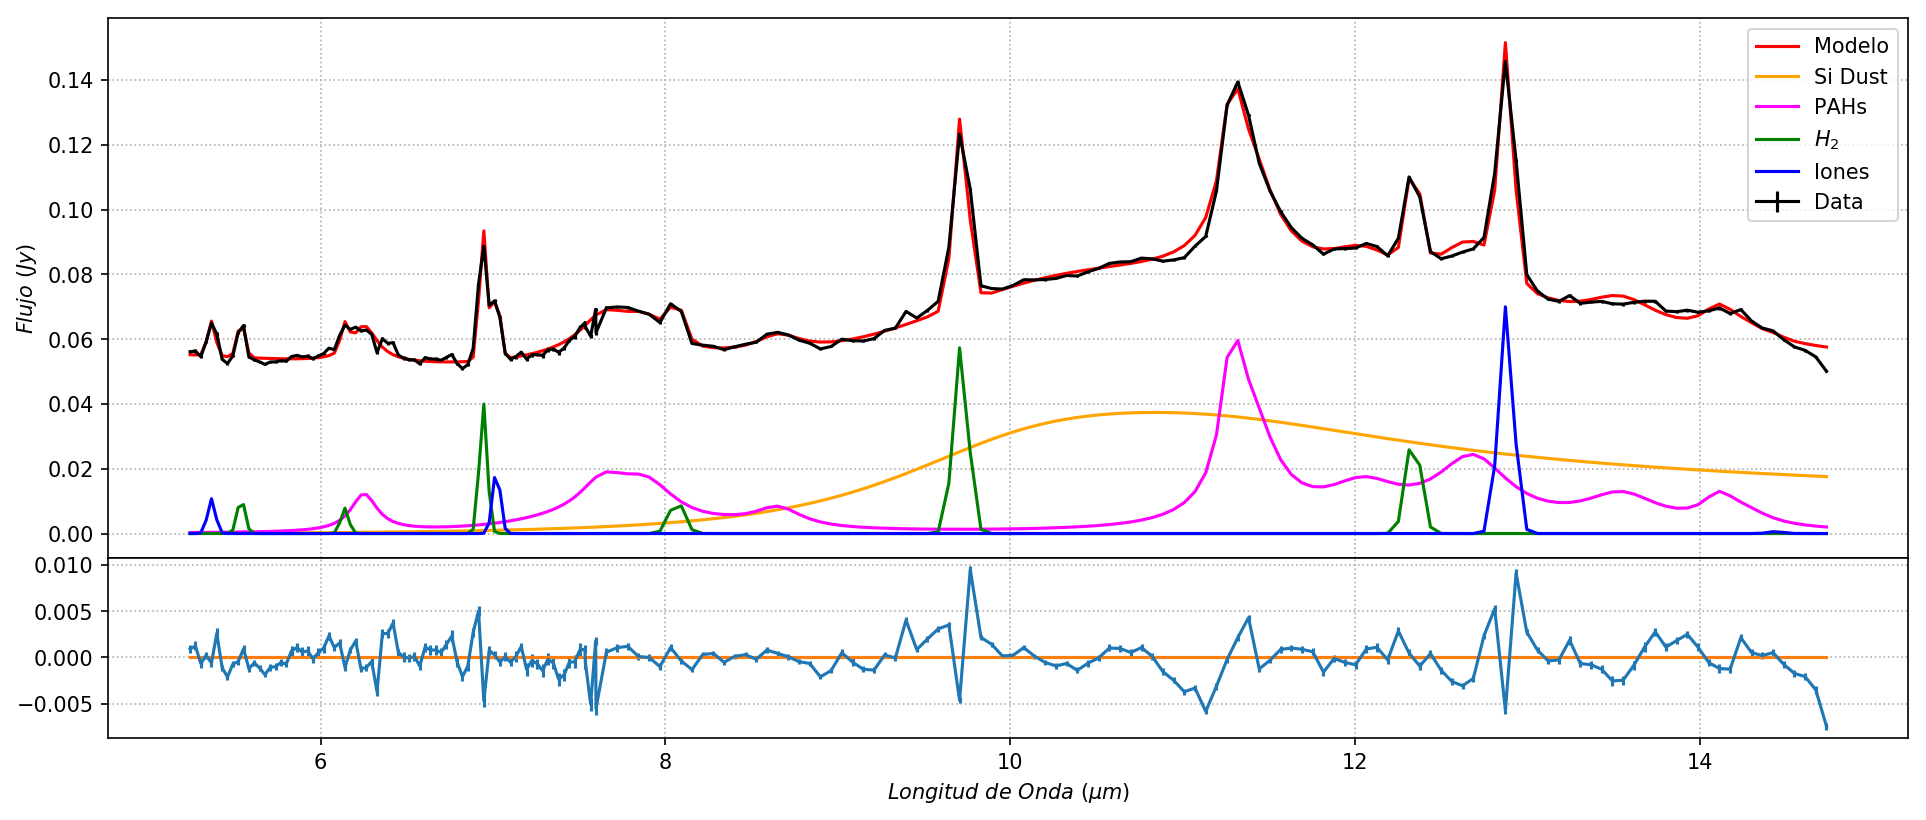

In [44]:
#Nucleus spectrum
spec=nuc_spec
specerr=nuc_err

#Model (powerlaw + AGN silicate emission + individual PAHs + H2 and Atomic lines, no extinction)
model = p_law + silicate + drudes + gaussH2 + gaussAt

#Adjust power law and silicate dust starting parameters
setpar(generic_pars,'pwl_c1',0.005,True,None)
setpar(generic_pars,'pwl_c2',0.01,True,None)
sidust_defpar('sidust1', 190.,2.E-4,generic_pars)

#Fit and plot
nuc_result=fit_and_plot(spec,specerr,model,generic_pars,True)

Time count
--- 0.25751423835754395 seconds ---
Chi square red= 33.96831941170625


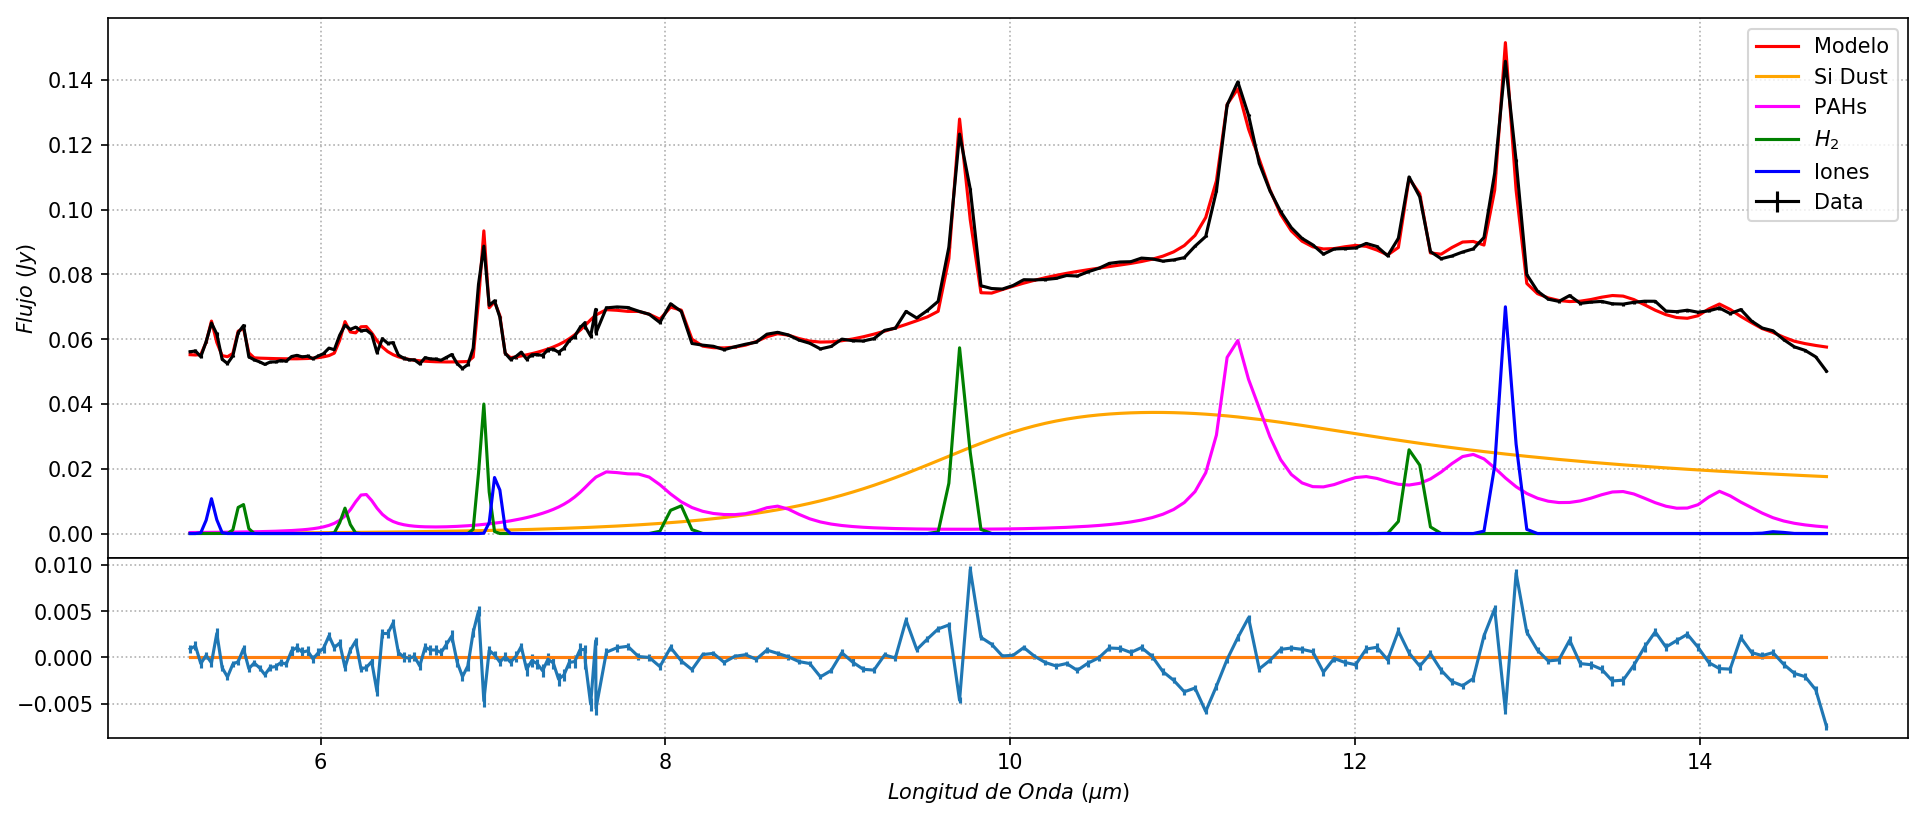

[[Model]]
    ((((Model(powerlaw, prefix='pwl_') + Model(sidust, prefix='sidust1_')) + ((((((((((((((Model(Modelcero) + Model(drude, prefix='PAH52_')) + Model(drude, prefix='PAH62_')) + Model(drude, prefix='PAH74_')) + Model(drude, prefix='PAH76_')) + Model(drude, prefix='PAH78_')) + Model(drude, prefix='PAH83_')) + Model(drude, prefix='PAH86_')) + Model(drude, prefix='PAH112_')) + Model(drude, prefix='PAH113_')) + Model(drude, prefix='PAH119_')) + Model(drude, prefix='PAH126_')) + Model(drude, prefix='PAH134_')) + Model(drude, prefix='PAH140_')) + Model(drude, prefix='PAH141_'))) + ((((((Model(Modelcero) + Model(gaussian, prefix='h55_')) + Model(gaussian, prefix='h61_')) + Model(gaussian, prefix='h69_')) + Model(gaussian, prefix='h80_')) + Model(gaussian, prefix='h96_')) + Model(gaussian, prefix='h122_'))) + ((((((Model(Modelcero) + Model(gaussian, prefix='FeII_')) + Model(gaussian, prefix='ArII_')) + Model(gaussian, prefix='ArIII_')) + Model(gaussian, prefix='SIV_')) + Model(gaussian

In [45]:
for par in nuc_result.params:
    value=nuc_result.params[par].value
    vary=nuc_result.params[par].vary
    minus=nuc_result.params[par].min
    if minus==float("-inf"):
        minus=None
    if abs(value)<=1e-7:
        value=0
        vary=False
        minus=None
    generic_pars[par].set(value,vary=vary,min=minus)
    
nuc_result=fit_and_plot(spec,specerr,model,generic_pars,True)
print(nuc_result.fit_report(show_correl=False))

Model fit to nucleus, including fixed-temperature AGN silicate emission. 

#### Bulge spectral fit

In [46]:
#Generic Parameters
#Power Law
p_law = Model(powerlaw,prefix='pwl_')
generic_pars = p_law.make_params()      #Generate the parameters
setpar(generic_pars,'pwl_c1',0.05,True,None)
setpar(generic_pars,'pwl_c2',0.015,True,None)

#Individual PAHs
drudes=Model(Modelcero)
allpahlines=['52','62','74','76','78','83','86','112','113','119','126','134','140','141'] 
for line in allpahlines:
    prefix='PAH'+line+'_'  
    drudes+=Model(drude,prefix=prefix)  
generic_pars.update(drudes.make_params())

drude_defpar('PAH52', 5.27, 0.034, 0.00005,generic_pars)
drude_defpar('PAH62', 6.22, 0.030, 0.05,generic_pars)
drude_defpar('PAH74', 7.42, 0.126, 0.05,generic_pars)
drude_defpar('PAH76', 7.60, 0.044, 0.05,generic_pars)
drude_defpar('PAH78', 7.85, 0.053, 0.5,generic_pars)
drude_defpar('PAH83', 8.33, 0.05, 0.5,generic_pars)
drude_defpar('PAH86', 8.61, 0.039, 0.5,generic_pars)
drude_defpar('PAH112', 11.23, 0.012, 0.5,generic_pars)
drude_defpar('PAH113', 11.33, 0.032, 0.5,generic_pars)
drude_defpar('PAH119', 11.99, 0.045, 0.5,generic_pars)
drude_defpar('PAH126', 12.62, 0.042, 0.0005,generic_pars)
drude_defpar('PAH134', 13.48, 0.04, 0.5,generic_pars)
drude_defpar('PAH140', 14.04, 0.016, 0.5,generic_pars)
drude_defpar('PAH141', 14.19, 0.025, 0.5,generic_pars)

#Silicate dust emission
prefix='sidust1_'
silicate= Model(sidust,prefix=prefix)
generic_pars.update(silicate.make_params())
sidust_defpar('sidust1', 190.,1.E-4,generic_pars)

#Gaussians with FWHM and X central from Smith et al 2007
#H2 molecular
h2lines=['55','61','69','80','96','122']
gaussH2=Model(Modelcero)
for line in h2lines:
    prefix='h'+line+'_'
    gaussH2+=Model(gaussian,prefix=prefix)
generic_pars.update(gaussH2.make_params())
gaussian_defpar('h55',0.0005, 5.511, 0.053,generic_pars)
gaussian_defpar('h61',0.0005, 6.109, 0.053,generic_pars)
gaussian_defpar('h69',0.0005, 6.909, 0.053,generic_pars)
gaussian_defpar('h80',0.0005, 8.026, 0.100,generic_pars)
gaussian_defpar('h96',0.0005, 9.665, 0.100,generic_pars)
gaussian_defpar('h122',0.0005, 12.278, 0.100,generic_pars)

#Atomic lines
atomiclines=['FeII','ArII','ArIII','SIV','NeII','ClII']
gaussAt=Model(Modelcero)
for line in atomiclines:
    prefix = line+'_'
    gaussAt+=Model(gaussian,prefix=prefix)
generic_pars.update(gaussAt.make_params())
gaussian_defpar('FeII',0.5, 5.34, 0.053,generic_pars)
gaussian_defpar('ArII',0.005, 6.985, 0.053,generic_pars)
gaussian_defpar('ArIII',0.0005, 8.991, 0.100,generic_pars)
gaussian_defpar('SIV',0.05, 10.511, 0.100,generic_pars)
gaussian_defpar('NeII',0.05, 12.813, 0.100,generic_pars)
gaussian_defpar('ClII',0.05, 14.37, 0.100,generic_pars)


Time count
--- 4.82248067855835 seconds ---
Chi square red= 13.186848298117702


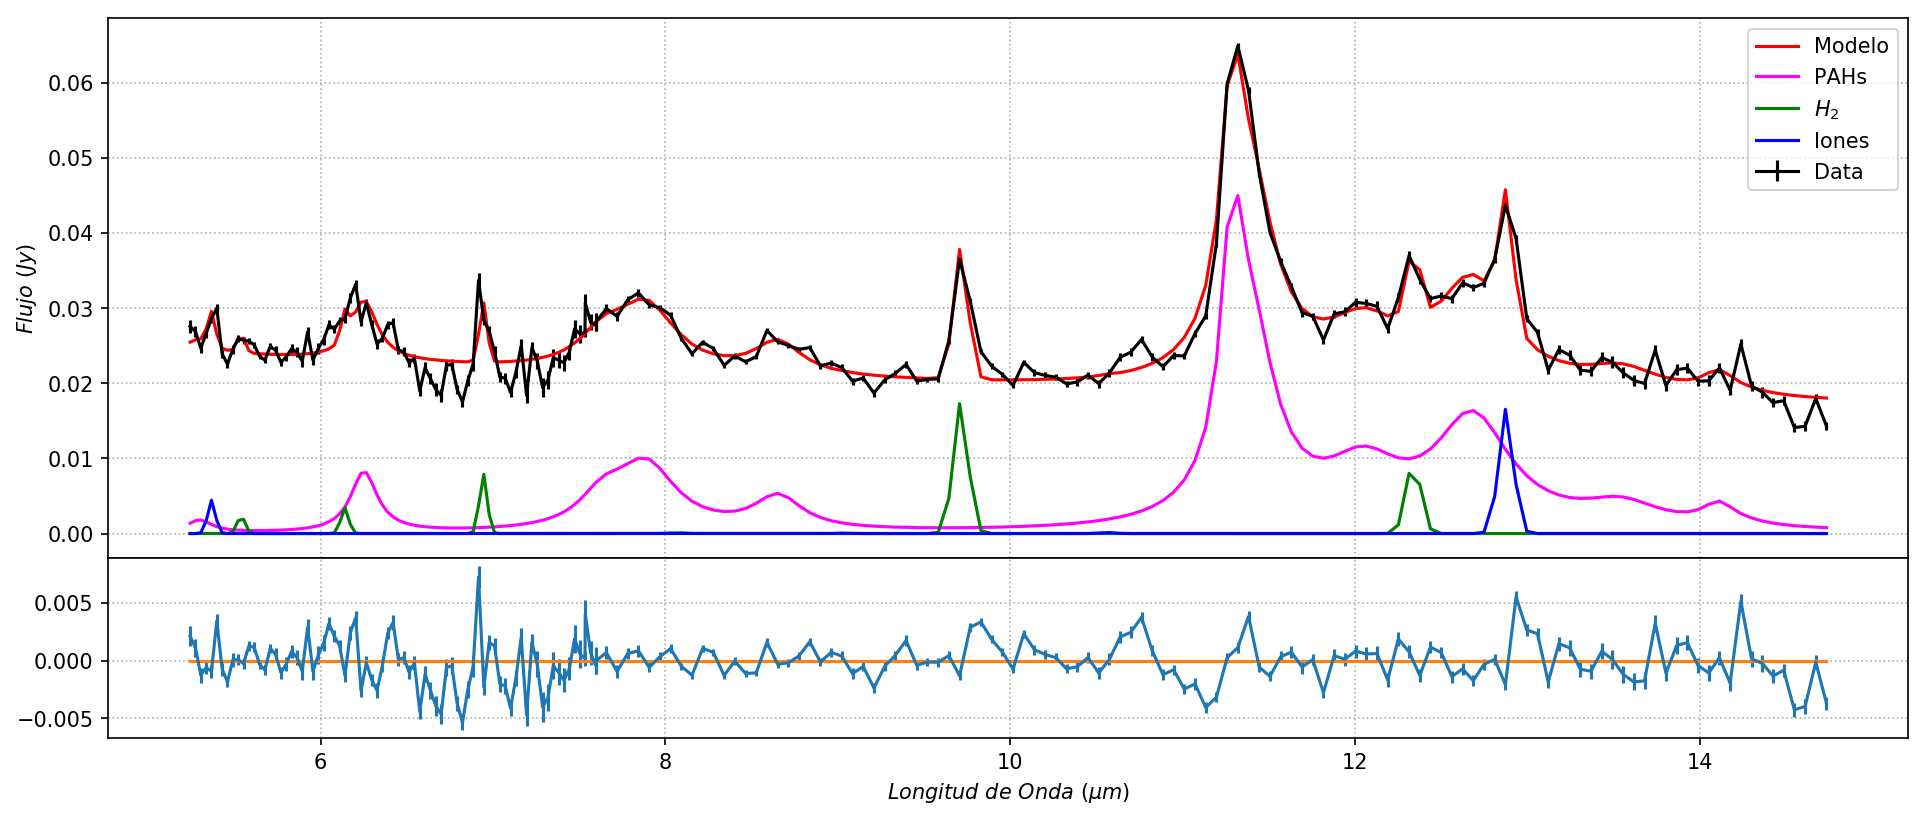

In [47]:
#Bulge spectrum
spec=pah_spec
specerr=pah_err

#Model (powerlaw + AGN silicate emission + individual PAHs + H2 and Atomic lines, no extinction)
model = p_law + drudes + gaussH2 + gaussAt

#Adjust power law and silicate dust starting parameters
setpar(generic_pars,'pwl_c1',0.005,True,None)
setpar(generic_pars,'pwl_c2',0.01,True,None)

#Fit and plot
pah_result=fit_and_plot(spec,specerr,model,generic_pars,False)

Time count
--- 0.30976057052612305 seconds ---
Chi square red= 12.724258788848152


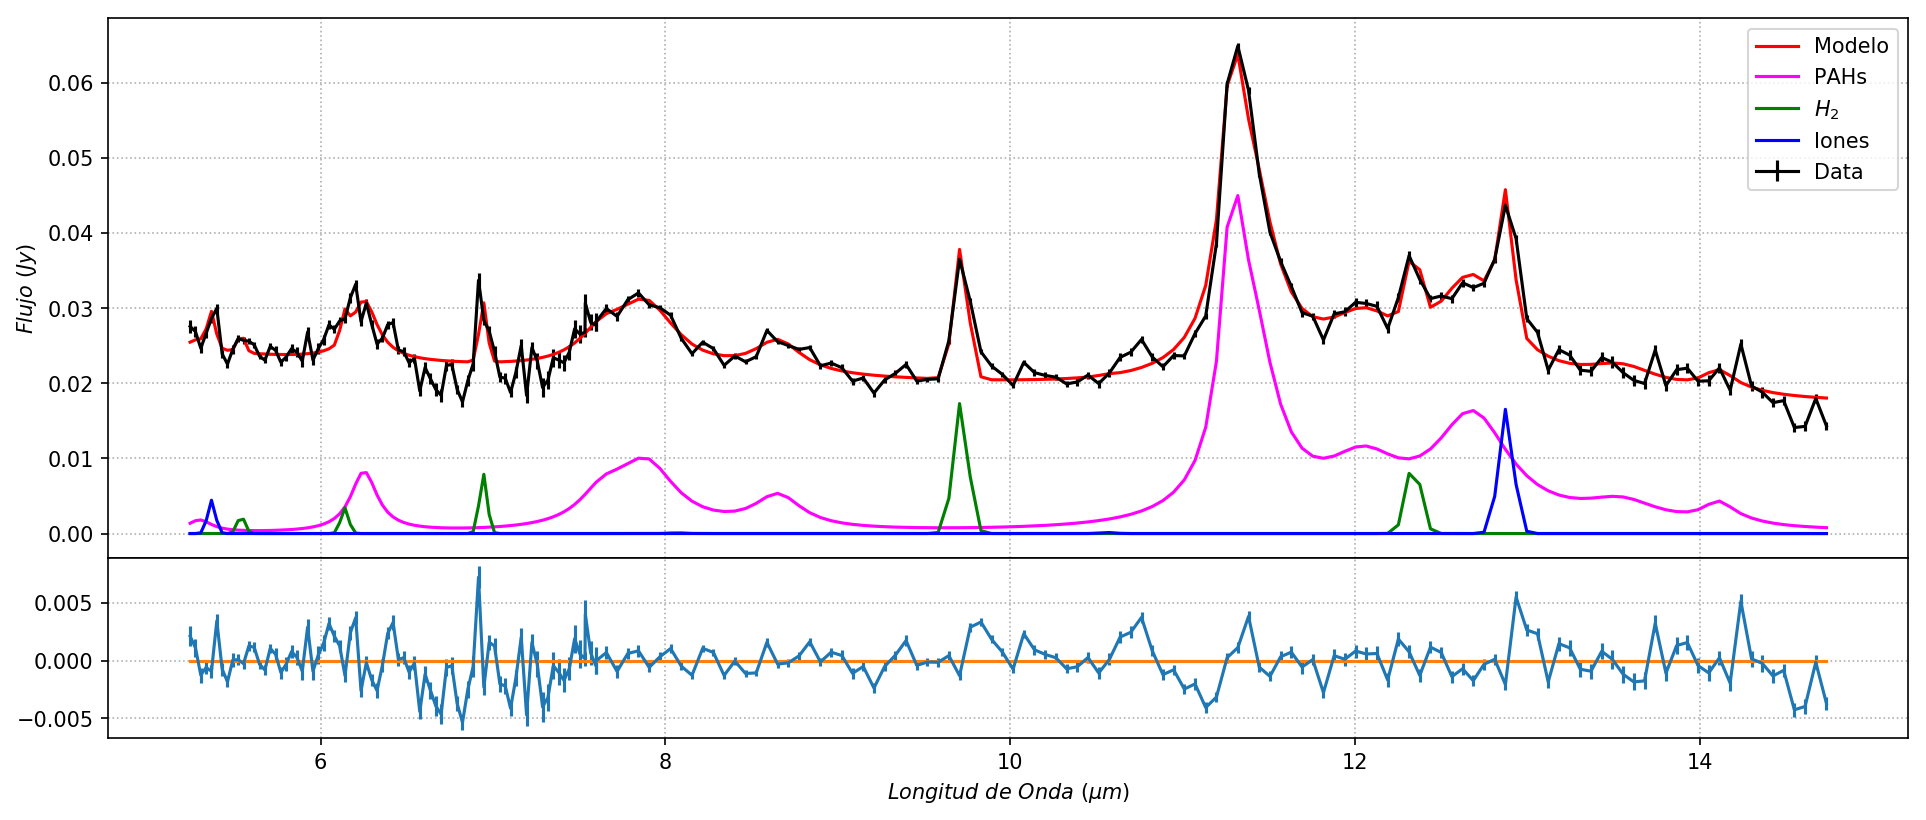

[[Model]]
    (((Model(powerlaw, prefix='pwl_') + ((((((((((((((Model(Modelcero) + Model(drude, prefix='PAH52_')) + Model(drude, prefix='PAH62_')) + Model(drude, prefix='PAH74_')) + Model(drude, prefix='PAH76_')) + Model(drude, prefix='PAH78_')) + Model(drude, prefix='PAH83_')) + Model(drude, prefix='PAH86_')) + Model(drude, prefix='PAH112_')) + Model(drude, prefix='PAH113_')) + Model(drude, prefix='PAH119_')) + Model(drude, prefix='PAH126_')) + Model(drude, prefix='PAH134_')) + Model(drude, prefix='PAH140_')) + Model(drude, prefix='PAH141_'))) + ((((((Model(Modelcero) + Model(gaussian, prefix='h55_')) + Model(gaussian, prefix='h61_')) + Model(gaussian, prefix='h69_')) + Model(gaussian, prefix='h80_')) + Model(gaussian, prefix='h96_')) + Model(gaussian, prefix='h122_'))) + ((((((Model(Modelcero) + Model(gaussian, prefix='FeII_')) + Model(gaussian, prefix='ArII_')) + Model(gaussian, prefix='ArIII_')) + Model(gaussian, prefix='SIV_')) + Model(gaussian, prefix='NeII_')) + Model(gaussian, 

In [48]:
for par in pah_result.params:
    value=pah_result.params[par].value
    vary=pah_result.params[par].vary
    minus=pah_result.params[par].min
    if minus==float("-inf"):
        minus=None
    if abs(value)<=1e-4:
        value=0
        vary=False
        minus=None
    generic_pars[par].set(value,vary=vary,min=minus)
    
pah_result=fit_and_plot(spec,specerr,model,generic_pars,False)
print(pah_result.fit_report(show_correl=False))

Fit parameters for spectrum of nucleus

In [49]:
#Save Models to file
#save_modelresult(pah_result, 'Bul_modelresult.sav')
#save_modelresult(arm_result, 'Arm_modelresult.sav')
#save_modelresult(h2_result, 'H2_modelresult.sav')
#save_modelresult(nuc_result, 'Nuc_modelresult.sav')

### Calculate Flux

In [84]:
def extract_all_g(line):
    center=result.params[line+'_xcen'].value
    ancho=result.params[line+'_std'].value
    amplit=result.params[line+'_amplitude'].value
    er_amplit=result.params[line+'_amplitude'].stderr
    return center, ancho, amplit, er_amplit


print('H2 & Lambda & Flux Nuc & Flux H2 & Flux Bul & Flux Arm')
trans=['S(7)','S(6)','S(5)','S(4)','S(3)','S(2)']
h2_list=['h55','h61','h69','h80','h96','h122']


i=0
for line in h2_list:
    result=nuc_result
    center, ancho, amplit, er_amplit = extract_all_g(line)
    nuc_flux=gaussianline_flux(amplit,ancho,center)
    nuc_eflux=gaussianline_flux(er_amplit,ancho,center)
    result=h2_result
    center, ancho, amplit, er_amplit = extract_all_g(line)
    h2_flux=gaussianline_flux(amplit,ancho,center)
    h2_eflux=gaussianline_flux(er_amplit,ancho,center)
    result=pah_result
    center, ancho, amplit, er_amplit = extract_all_g(line)
    bul_flux=gaussianline_flux(amplit,ancho,center)
    bul_eflux=gaussianline_flux(er_amplit,ancho,center)
    result=arm_result
    center, ancho, amplit, er_amplit = extract_all_g(line)
    arm_flux=gaussianline_flux(amplit,ancho,center)
    arm_eflux=gaussianline_flux(er_amplit,ancho,center)
    print('{:} & {:4.3f} & {:3.2f} ({:4.2f}) & {:3.2f} ({:4.2f}) & {:3.2f} ({:4.2f}) & {:3.2f} ({:4.2f}) \\\\'.format(trans[i],center/OneZ, nuc_flux/1e-14,  nuc_eflux/1e-14, h2_flux/1e-14,  h2_eflux/1e-14, bul_flux/1e-14,  bul_eflux/1e-14, arm_flux/1e-14,  arm_eflux/1e-14))
    i+=1

H2 & Lambda & Flux Nuc & Flux H2 & Flux Bul & Flux Arm
S(7) & 5.511 & 5.95 (1.03) & 7.15 (1.07) & 1.27 (0.84) & 0.00 (0.00) \\
S(6) & 6.109 & 3.52 (0.96) & 5.01 (0.97) & 1.54 (0.80) & 0.00 (0.00) \\
S(5) & 6.909 & 14.15 (1.20) & 15.55 (0.94) & 2.79 (0.79) & 0.35 (0.31) \\
S(4) & 8.026 & 5.05 (1.02) & 6.21 (0.89) & 0.06 (0.65) & 0.24 (0.32) \\
S(3) & 9.665 & 19.64 (0.59) & 27.14 (0.55) & 5.93 (0.42) & 0.17 (0.19) \\
S(2) & 12.278 & 6.45 (0.48) & 9.78 (0.50) & 2.00 (0.40) & 0.46 (0.22) \\


In [92]:
print('Line & Lambda & Flux Nuc & Flux H2 & Flux Bul & Flux Arm')
trans=['[FeII]','[ArII]','[ArIII]','[SIV]','[NeII]','[ClII]']
ion_list=['FeII','ArII','ArIII','SIV','NeII','ClII']

i=0
for line in ion_list:
    result=nuc_result
    center, ancho, amplit, er_amplit = extract_all_g(line)
    nuc_flux=gaussianline_flux(amplit,ancho,center)
    nuc_eflux=gaussianline_flux(er_amplit,ancho,center)
    result=h2_result
    center, ancho, amplit, er_amplit = extract_all_g(line)
    h2_flux=gaussianline_flux(amplit,ancho,center)
    h2_eflux=gaussianline_flux(er_amplit,ancho,center)
    result=pah_result
    center, ancho, amplit, er_amplit = extract_all_g(line)
    bul_flux=gaussianline_flux(amplit,ancho,center)
    bul_eflux=gaussianline_flux(er_amplit,ancho,center)
    result=arm_result
    center, ancho, amplit, er_amplit = extract_all_g(line)
    arm_flux=gaussianline_flux(amplit,ancho,center)
    arm_eflux=gaussianline_flux(er_amplit,ancho,center)
    print('{:} & {:4.3f} & {:3.2f} ({:4.2f}) & {:3.2f} ({:4.2f}) & {:3.2f} ({:4.2f}) & {:3.2f} ({:4.2f}) \\\\'.format(trans[i],center/OneZ, nuc_flux/1e-14,  nuc_eflux/1e-14, h2_flux/1e-14,  h2_eflux/1e-14, bul_flux/1e-14,  bul_eflux/1e-14, arm_flux/1e-14,  arm_eflux/1e-14))
    i+=1

Line & Lambda & Flux Nuc & Flux H2 & Flux Bul & Flux Arm
[FeII] & 5.340 & 6.31 (1.31) & 5.08 (1.54) & 2.60 (1.30) & 0.00 (0.00) \\
[ArII] & 6.985 & 6.74 (0.87) & 2.78 (0.90) & 0.00 (0.00) & 0.00 (0.00) \\
[ArIII] & 8.991 & 0.00 (0.00) & 0.00 (0.00) & 0.00 (0.00) & 0.04 (0.22) \\
[SIV] & 10.511 & 0.00 (0.00) & 0.09 (0.54) & 0.04 (0.49) & 0.00 (0.00) \\
[NeII] & 12.813 & 13.52 (0.43) & 7.82 (0.38) & 3.20 (0.35) & 0.83 (0.17) \\
[ClII] & 14.370 & 0.09 (0.34) & 0.53 (0.39) & 0.00 (0.00) & 0.00 (0.00) \\


In [99]:
def extract_all_d(line):
    line='PAH'+line
    center=result.params[line+'_peakx'].value
    ancho=result.params[line+'_frac_FWHM'].value
    amplit=result.params[line+'_amplitude'].value
    er_amplit=result.params[line+'_amplitude'].stderr
    return center, ancho, amplit, er_amplit

print('PAH & Flux Nuc & Flux H2 & Flux Bul & Flux Arm')
allpahlines=['52','62','77','83','86','113','119','126','134','140','141'] 

for line in allpahlines:
    if line == '77':
        arm_flux=0
        arm_eflux=0
        bul_flux=0
        bul_eflux=0
        nuc_flux=0
        nuc_eflux=0
        h2_flux=0
        h2_eflux=0
        pah77=['74','76','78']                                 #Create a list for the complex lines
        for complexline in pah77:
            result=nuc_result
            center, ancho, amplit, er_amplit = extract_all_d(complexline)
            nuc_flux+=drudeline_flux(amplit,ancho,center)
            nuc_eflux+=drudeline_flux(er_amplit,ancho,center)
            result=h2_result
            center, ancho, amplit, er_amplit = extract_all_d(complexline)
            h2_flux+=drudeline_flux(amplit,ancho,center)
            h2_eflux+=drudeline_flux(er_amplit,ancho,center)
            result=pah_result
            center, ancho, amplit, er_amplit = extract_all_d(complexline)
            bul_flux+=drudeline_flux(amplit,ancho,center)
            bul_eflux+=drudeline_flux(er_amplit,ancho,center)
            result=arm_result
            center, ancho, amplit, er_amplit = extract_all_d(complexline)
            arm_flux+=drudeline_flux(amplit,ancho,center)
            arm_eflux+=drudeline_flux(er_amplit,ancho,center)
        center=7.7*OneZ
    elif line == '113':
        arm_flux=0
        arm_eflux=0
        bul_flux=0
        bul_eflux=0
        nuc_flux=0
        nuc_eflux=0
        h2_flux=0
        h2_eflux=0
        pah113=['112','113']                                 #Create a list for the complex lines
        for complexline in pah113:
            result=nuc_result
            center, ancho, amplit, er_amplit = extract_all_d(complexline)
            nuc_flux+=drudeline_flux(amplit,ancho,center)
            nuc_eflux+=drudeline_flux(er_amplit,ancho,center)
            result=h2_result
            center, ancho, amplit, er_amplit = extract_all_d(complexline)
            h2_flux+=drudeline_flux(amplit,ancho,center)
            h2_eflux+=drudeline_flux(er_amplit,ancho,center)
            result=pah_result
            center, ancho, amplit, er_amplit = extract_all_d(complexline)
            bul_flux+=drudeline_flux(amplit,ancho,center)
            bul_eflux+=drudeline_flux(er_amplit,ancho,center)
            result=arm_result
            center, ancho, amplit, er_amplit = extract_all_d(complexline)
            arm_flux+=drudeline_flux(amplit,ancho,center)
            arm_eflux+=drudeline_flux(er_amplit,ancho,center)
        center=11.3*OneZ
    else:
        result=nuc_result
        center, ancho, amplit, er_amplit = extract_all_d(line)
        nuc_flux=drudeline_flux(amplit,ancho,center)
        nuc_eflux=drudeline_flux(er_amplit,ancho,center)
        result=h2_result
        center, ancho, amplit, er_amplit = extract_all_d(line)
        h2_flux=drudeline_flux(amplit,ancho,center)
        h2_eflux=drudeline_flux(er_amplit,ancho,center)
        result=pah_result
        center, ancho, amplit, er_amplit = extract_all_d(line)
        bul_flux=drudeline_flux(amplit,ancho,center)
        bul_eflux=drudeline_flux(er_amplit,ancho,center)
        result=arm_result
        center, ancho, amplit, er_amplit = extract_all_d(line)
        arm_flux=drudeline_flux(amplit,ancho,center)
        arm_eflux=drudeline_flux(er_amplit,ancho,center)
    print('{:3.2f} & {:3.2f} ({:4.2f}) & {:3.2f} ({:4.2f}) & {:3.2f} ({:4.2f}) & {:3.2f} ({:4.2f}) \\\\'.format(center/OneZ, nuc_flux/1e-14,  nuc_eflux/1e-14, h2_flux/1e-14,  h2_eflux/1e-14, bul_flux/1e-14,  bul_eflux/1e-14, arm_flux/1e-14,  arm_eflux/1e-14))
    i+=1

PAH & Flux Nuc & Flux H2 & Flux Bul & Flux Arm
5.27 & 0.00 (0.00) & 10.80 (6.43) & 5.07 (5.03) & 2.51 (1.80) \\
6.22 & 26.11 (2.76) & 22.20 (2.96) & 18.20 (2.52) & 10.62 (1.11) \\
7.70 & 92.69 (25.22) & 44.83 (8.05) & 37.69 (7.23) & 29.93 (3.14) \\
8.33 & 1.86 (3.13) & 0.00 (0.00) & 0.00 (0.00) & 2.89 (0.97) \\
8.61 & 13.16 (2.56) & 6.49 (1.65) & 9.32 (1.45) & 6.45 (0.73) \\
11.30 & 61.72 (3.40) & 61.60 (3.27) & 47.66 (2.70) & 14.31 (1.29) \\
11.99 & 20.01 (2.15) & 18.75 (2.04) & 12.86 (1.78) & 3.73 (0.84) \\
12.62 & 32.36 (1.75) & 32.18 (1.64) & 22.23 (1.47) & 6.66 (0.70) \\
13.48 & 13.59 (2.05) & 9.55 (1.81) & 4.07 (1.63) & 0.64 (0.83) \\
14.04 & 4.02 (1.28) & 1.93 (1.29) & 1.46 (1.17) & 0.00 (0.00) \\
14.19 & 3.29 (1.76) & 6.35 (1.78) & 0.25 (1.50) & 0.00 (0.00) \\


<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

Notebook created by Patrick Ogle and Ivan Lopez.